In [1]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')

    library(lme4)
    library(furrr)
    library(future)
    library(arm)    
    library(harmony)
    library(magick)
    library(ggrastr)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(igraph)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(spatula)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(tidyr)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

# ## Clustering functions 
# source('../../ModularityClustering/R/modularity_clustering.R')
# sourceCpp('../../ModularityClustering/src/RModularityOptimizer.cpp')


source('utils_plotting.R')
source('utils.R')


# Data

## MERFISH

In [3]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell <- as.character(meta_data$cell)
counts <- spatula::readMM('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
rownames(counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(counts) <- meta_data$cell


In [4]:
head(meta_data)

cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,immune_other,Lymphocyte,B
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,immune_other,Epithelial,Epithelial
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,immune_other,Epithelial,Epithelial
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,immune_other,Epithelial,Epithelial
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,immune_other,Epithelial,Epithelial


In [5]:
sort(unique(meta_data$type_lvl1))

[1] ""           "Epithelial" "Fibroblast" "Lymphocyte" "Mast"      
[6] "Myeloid"    "Plasma"     "Vascular"

## Single Cell

In [6]:
obj = readRDS('../data/stromal_ref_lee_lung.rds')

In [7]:
head(meta_data)

cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,immune_other,Lymphocyte,B
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,immune_other,Epithelial,Epithelial
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,immune_other,Epithelial,Epithelial
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,immune_other,Epithelial,Epithelial
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,immune_other,Epithelial,Epithelial


In [8]:
table(meta_data$type_lvl1)



           Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma 
    102471     766743     186554     123664       5072     274239      44010 
  Vascular 
     88588 

# Subtype all stromal cells

## data

In [9]:
meta_data = meta_data[type_lvl1 %in% c('Vascular', 'Fibroblast', 'Vascular')]
counts = counts[, meta_data$cell]


In [10]:
ref = readRDS('../data/stromal_ref_lee_lung.rds')

In [11]:
table(ref@meta.data$Cell_type)


Endothelial cells       Fibroblasts 
              617              1530 

## Gene selection

In [12]:
ref_markers = fread('../data/stromal_ref_lee_lung_markers.csv')

In [13]:
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
length(genes_ref)


[1] 174

## harmonize

In [16]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        # spa@assays$RNA@counts[genes_ref, ],
        counts[genes_ref, ], 
        ref@assays$RNA@counts[genes_ref, ]
    ),
    meta.data = bind_rows(
        # spatial = dplyr::select(spa@meta.data, batch=library, type_lvl2), 
        spatial = meta_data %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(ref@meta.data, batch=Sample, seurat_clusters), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)



In [18]:
dim(obj)

[1]    174 277289

In [70]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
   2147  275142 


 FALSE 
277289 

In [71]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 167.5

In [83]:
library(openblasctl)
openblas_set_num_threads(10)


Warning message:
“The following arguments are not used: nselect”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 13864450)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



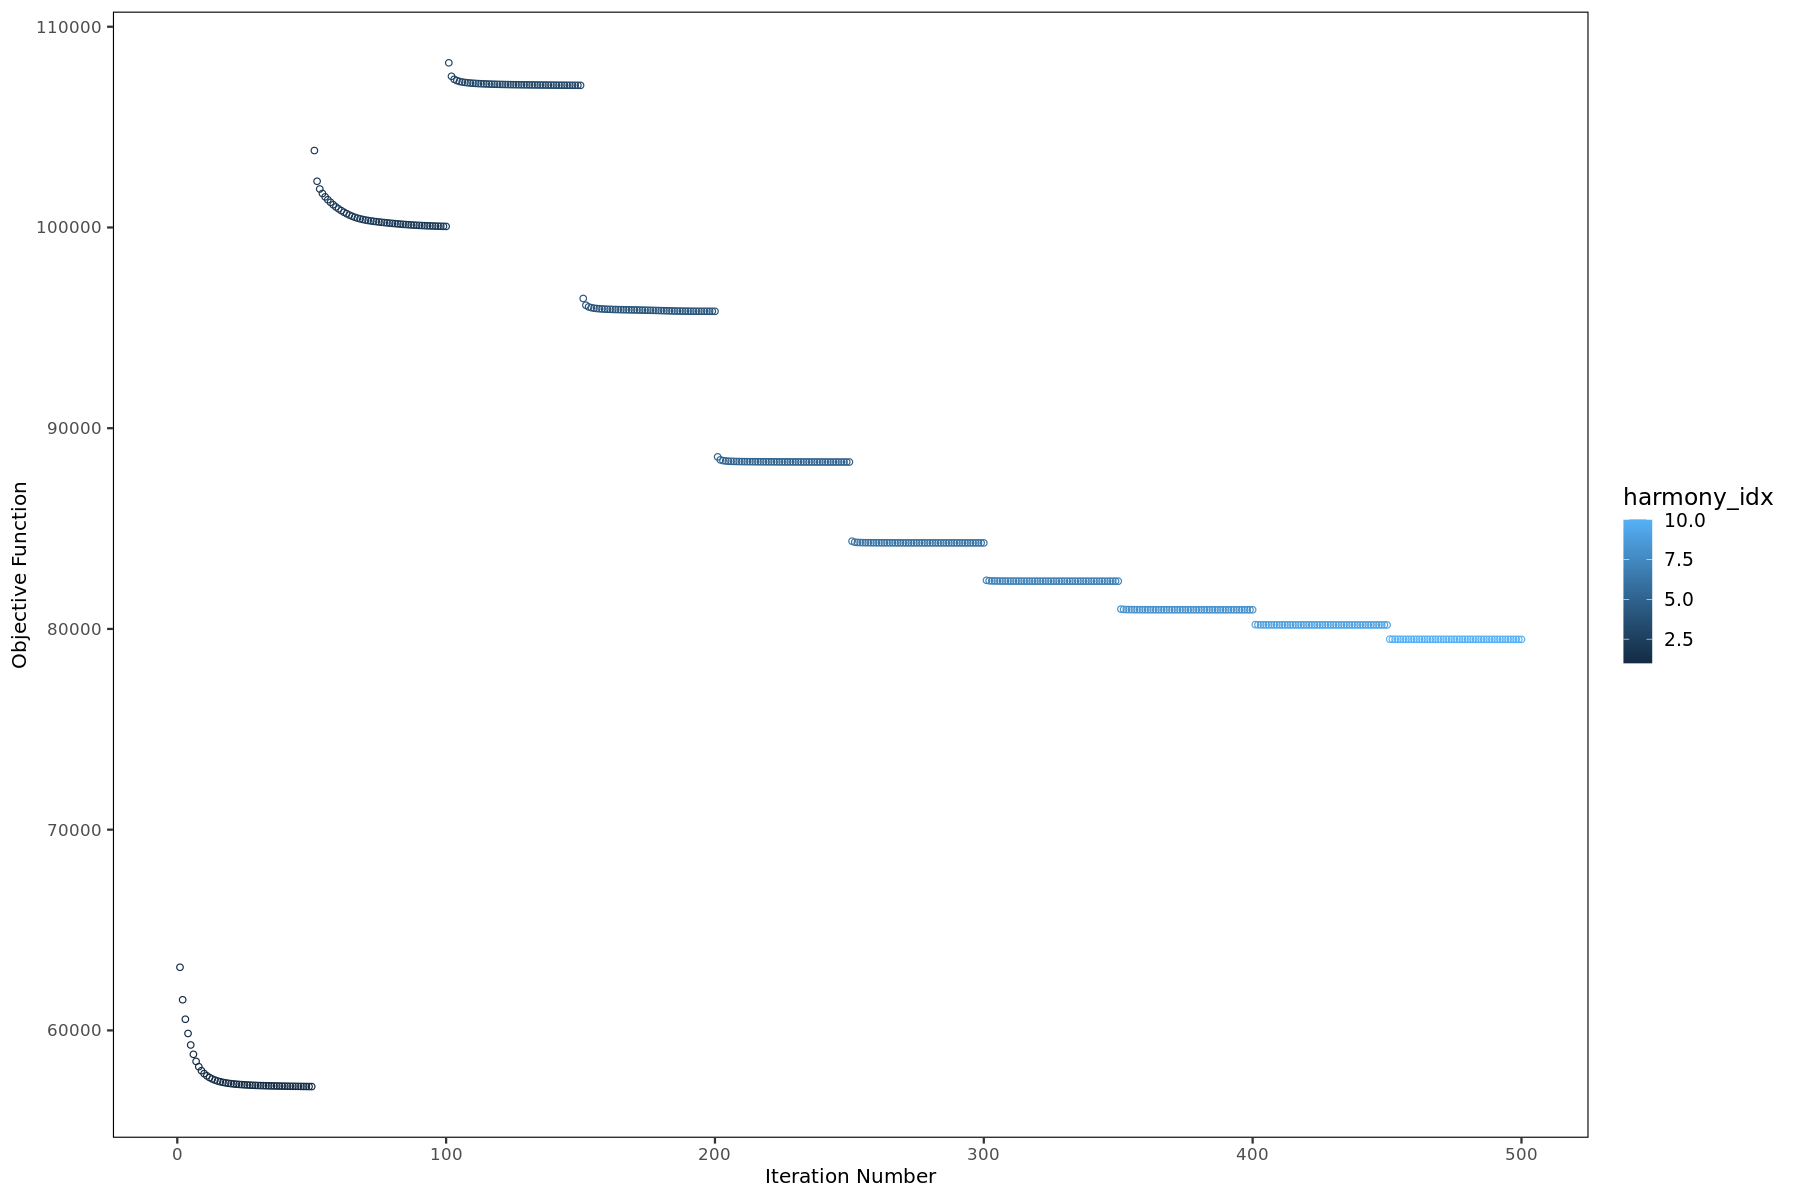

In [84]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [88]:
library(Seurat)

In [86]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')

In [89]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



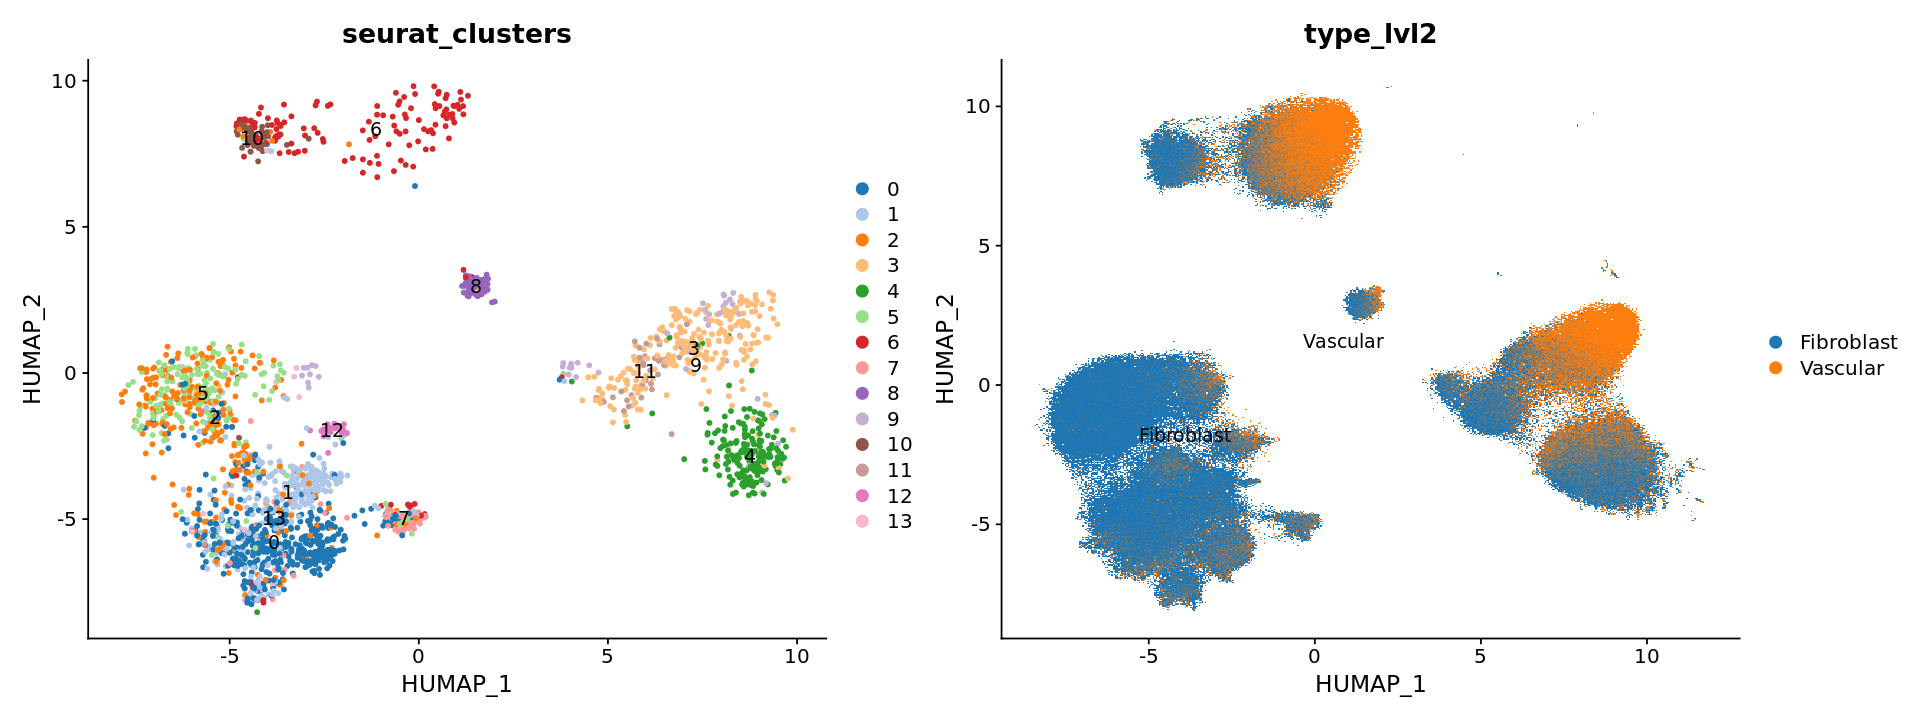

In [90]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 10') 


In [91]:
plan(multicore)
resolutions_test <- seq(0.05, 1.5, length.out = 10)
suppressWarnings({
    obj <- Seurat::FindClusters(obj, graph.name = 'humap_fgraph', resolution = resolutions_test, verbose = FALSE)        
})


In [92]:
obj@meta.data %>% 
    dplyr::select(matches('humap_fgraph_res')) %>% 
    map_int(nlevels) 

# obj@meta.data %>% 
#     dplyr::select(matches('humap_fgraph_res')) %>% 
#     map_int(nlevels) 


humap_fgraph_res.0.05 humap_fgraph_res.0.211111111111111 
                                 6                                 11 
humap_fgraph_res.0.372222222222222 humap_fgraph_res.0.533333333333333 
                                13                                 16 
humap_fgraph_res.0.694444444444444 humap_fgraph_res.0.855555555555556 
                                17                                 19 
 humap_fgraph_res.1.01666666666667  humap_fgraph_res.1.17777777777778 
                                18                                 17 
 humap_fgraph_res.1.33888888888889               humap_fgraph_res.1.5 
                                21                                 19

In [113]:
# obj@meta.data$seurat_clusters <- obj@meta.data$humap_fgraph_res.1.5
obj@meta.data$seurat_clusters <- obj@meta.data$humap_fgraph_res.0.694444444444444
Idents(obj) = obj$seurat_clusters

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



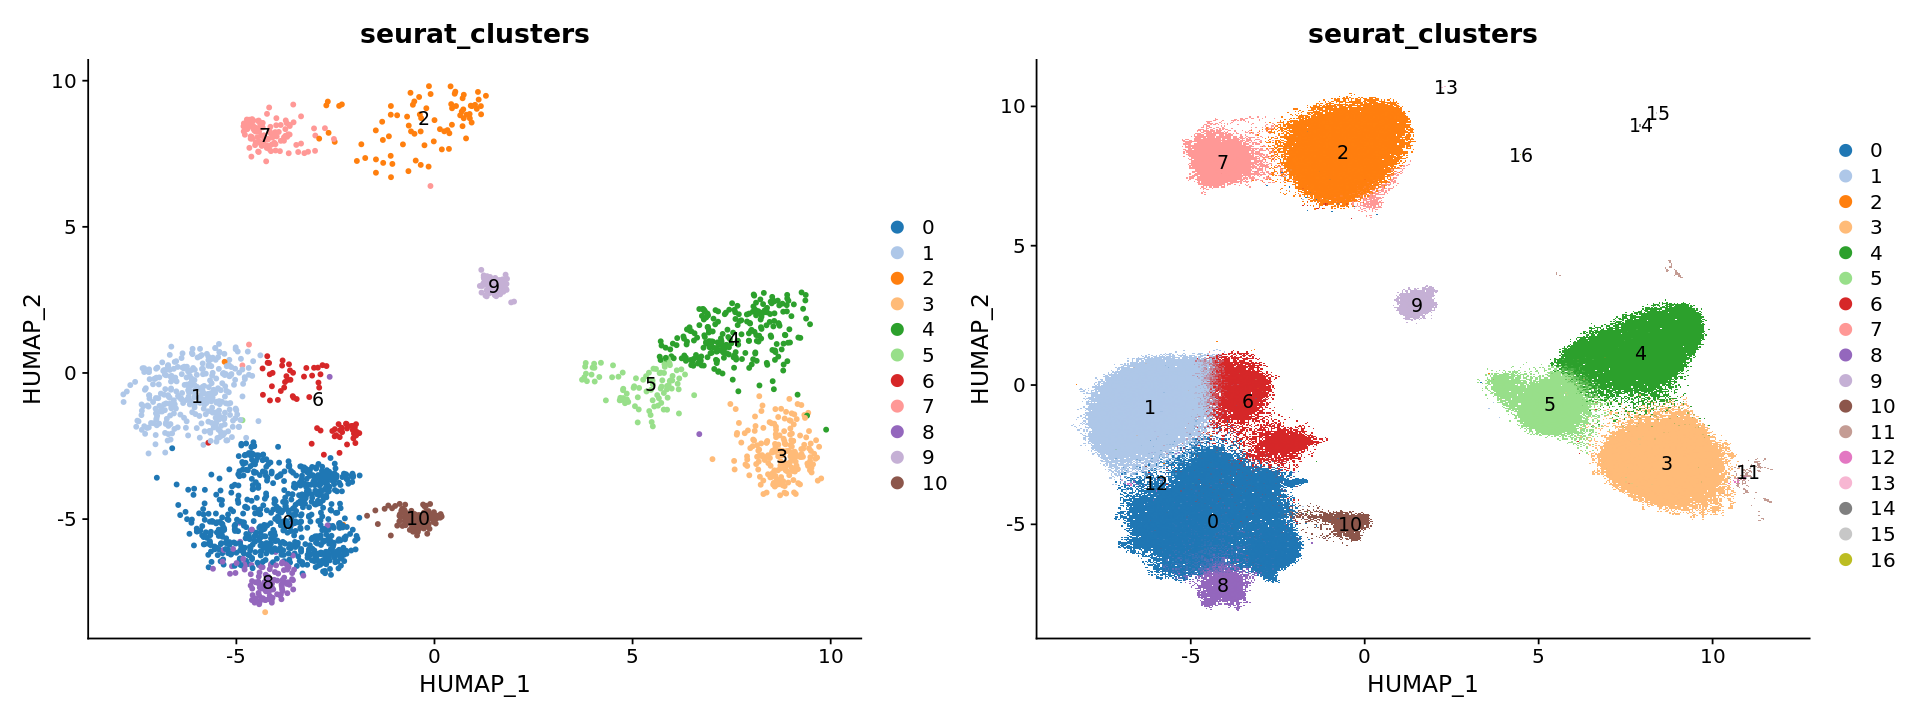

In [114]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 20') 


## spatial markers

In [95]:
markers_spa = get_markers(
    obj@assays$RNA@counts[, rownames(filter(obj@meta.data, type == 'spatial'))],
    obj@meta.data %>% filter(type == 'spatial') %>% dplyr::rename(library = batch),
    'seurat_clusters'
) 

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


In [96]:
markers_ref = get_markers(
    obj@assays$RNA@counts[, rownames(filter(obj@meta.data, type == 'sc'))],
    obj@meta.data %>% filter(type == 'sc') %>% dplyr::rename(library = batch),
    'seurat_clusters'
) 

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


In [101]:
message('Spatial:')
markers_spa %>% filter(feature == 'CCL19') %>% head()
message('Atlas:')
markers_ref %>% filter(feature == 'CCL19') %>% head()




Spatial:



cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,CCL19,6.56739689,2.0789833,3.15894644,0.0007917029,0.03781546
9,CCL19,0.46794825,2.0822113,0.22473620,0.4110922515,0.96908732
5,CCL19,0.15357597,1.1810794,0.13003019,0.4482712701,0.96908732
8,CCL19,0.03811059,0.8473262,0.04497747,0.4820626338,0.96908732
13,CCL19,-0.10851145,1.6072753,-0.06751267,0.5269132123,0.96908732
12,CCL19,-0.29797323,2.0821568,-0.14310797,0.5568975439,0.96908732


Atlas:



cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,CCL19,8.8928827,2.595862,3.4257922,0.0003065046,0.005534431
8,CCL19,2.4141493,1.558049,1.5494690,0.0606345146,0.311137965
2,CCL19,1.6814404,1.448286,1.1609864,0.1228237223,0.505246091
0,CCL19,1.1773168,1.355674,0.8684367,0.1925776590,0.680062065
1,CCL19,0.1552751,1.367241,0.1135682,0.4547900342,1.000000000
7,CCL19,-0.5851129,1.227998,-0.4764769,0.6831326682,1.000000000


In [103]:
head(obj@meta.data)

,orig.ident,type,batch,type_lvl2,seurat_clusters,nCount_RNA,nFeature_RNA,humap_fgraph_res.0.05,humap_fgraph_res.0.211111111111111,humap_fgraph_res.0.372222222222222,humap_fgraph_res.0.533333333333333,humap_fgraph_res.0.694444444444444,humap_fgraph_res.0.855555555555556,humap_fgraph_res.1.01666666666667,humap_fgraph_res.1.17777777777778,humap_fgraph_res.1.33888888888889,humap_fgraph_res.1.5
,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
31,SeuratProject,spatial,Patient001,Fibroblast,6,12,7,0,0,6,8,6,10,12,7,12,7
61,SeuratProject,spatial,Patient001,Vascular,5,19,16,1,2,3,2,5,5,5,3,5,6
66,SeuratProject,spatial,Patient001,Vascular,3,8,8,1,4,4,4,3,2,2,2,2,2
78,SeuratProject,spatial,Patient001,Fibroblast,1,8,8,0,1,1,0,1,0,0,0,0,0
106,SeuratProject,spatial,Patient001,Vascular,4,15,10,1,2,3,2,4,3,3,5,3,3
111,SeuratProject,spatial,Patient001,Fibroblast,0,44,26,0,0,0,1,0,4,4,4,4,4


In [98]:
# markers_ref %>% 
#     split(.$cluster) %>% 
#     map(dplyr::arrange, -logFC) %>% 
#     map(head)

markers_spa %>% 
    split(.$cluster) %>% 
    map(dplyr::arrange, -logFC) %>% 
    map(head, 10)


cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,RSPO3,2.516186,1.0374179,2.425431,7.645101e-03,0.1605471292
0,FOSB,2.339902,0.6704652,3.489968,2.415393e-04,0.0178299947
0,BMP5,2.144065,0.9117837,2.351506,9.348796e-03,0.1896594689
0,WNT2,1.984027,1.0479541,1.893239,2.916307e-02,0.4051594791
0,EGR1,1.873282,0.4068449,4.604412,2.068161e-06,0.0004198367
0,GAS1,1.852310,0.8299585,2.231810,1.281375e-02,0.2329425683
0,G0S2,1.567342,0.4806576,3.260829,5.554350e-04,0.0322152318
0,APOE,1.565716,0.4345208,3.603316,1.570913e-04,0.0131956705
0,GPNMB,1.536375,0.5111275,3.005855,1.324178e-03,0.0496261093


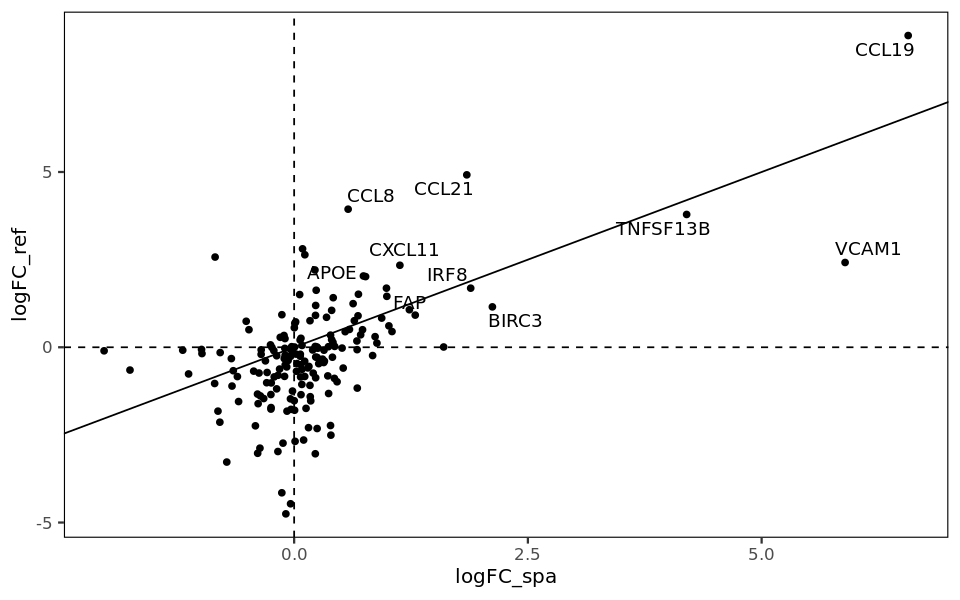

In [102]:
fig.size(5, 8)
full_join(
    markers_spa %>% filter(cluster == '10'),
    markers_ref %>% filter(cluster == '10'),
    by = c('cluster', 'feature'),
    suffix = c('_spa', '_ref')
) %>% 
    ggplot(aes(logFC_spa, logFC_ref)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point() +
        geom_abline() + 
        geom_text_repel(
            data = . %>% filter(logFC_spa > 0) %>% arrange(-abs(logFC_spa * logFC_ref)) %>% head(10),
            aes(label = feature)
        ) + 
        NULL


## Label them 

In [131]:
res = obj@meta.data %>% 
    # filter(type == 'spatial') %>% 
    tibble::rownames_to_column('cell') %>% 
    dplyr::select(cell, type, batch, seurat_clusters) %>% 
    left_join(
        tribble(
            ~seurat_clusters, ~type_lvl1, ~type_lvl2,
            '0', 'Fibroblast', 'RSPO3+', 
            '6', 'Fibroblast', '', 
            '5', 'Endothelial', '', 
            '11', 'Endothelial', '', 
            '1', 'Fibroblast', 'FN+', 
            '8', 'Fibroblast', 'IL6+', 
            '10', 'Fibroblast', 'CCL19+', 
            '9', 'Endothelial', 'Lymphatic',
            '3', 'Endothelial', 'Venous',
            '4', 'Endothelial', 'Arterial',
            '7', 'SmoothMuscle', 'SmoothMuscle',
            '2', 'Pericyte', 'Pericyte'
            ## outliers: 6, 5, 11
        )
    ) %>% 
    dplyr::select(cell, type, batch, seurat_clusters, type_lvl1, type_lvl2) %>% 
    cbind(obj@reductions$humap@cell.embeddings)
    # with(table(is.na(type_lvl2), seurat_clusters))


Joining with `by = join_by(seurat_clusters)`


In [132]:
head(res)

,cell,type,batch,seurat_clusters,type_lvl1,type_lvl2,HUMAP_1,HUMAP_2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
31,31,spatial,Patient001,6,Fibroblast,,-2.161101,-2.064576645
61,61,spatial,Patient001,5,Endothelial,,5.902034,0.005224887
66,66,spatial,Patient001,3,Endothelial,Venous,7.192262,-2.228913803
78,78,spatial,Patient001,1,Fibroblast,FN+,-4.677952,-0.951800247
106,106,spatial,Patient001,4,Endothelial,Arterial,8.327130,0.892030875
111,111,spatial,Patient001,0,Fibroblast,RSPO3+,-4.820428,-5.137191792


## Redo markers

In [26]:
res = fread('../data/stromal_fine_types.csv')


In [28]:
head(res)

cell,type,batch,seurat_clusters,type_lvl1,type_lvl2,HUMAP_1,HUMAP_2
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
31,spatial,Patient001,6,Fibroblast,,-2.161101,-2.064576645
61,spatial,Patient001,5,Endothelial,,5.902034,0.005224887
66,spatial,Patient001,3,Endothelial,Venous,7.192262,-2.228913803
78,spatial,Patient001,1,Fibroblast,FN+,-4.677952,-0.951800247
106,spatial,Patient001,4,Endothelial,Arterial,8.327130,0.892030875
111,spatial,Patient001,0,Fibroblast,RSPO3+,-4.820428,-5.137191792


In [41]:
i = which(res$type == 'spatial' & res$type_lvl2 != '')
markers_spa = get_markers(
    obj@assays$RNA@counts[, i],
    res[i, ] %>% dplyr::rename(library = batch),
    'type_lvl2'
) 


CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


In [40]:
i = which(res$type == 'sc' & res$type_lvl2 != '')
markers_ref = get_markers(
    obj@assays$RNA@counts[, i],
    res[i, ] %>% dplyr::rename(library = batch),
    'type_lvl2'
) 


CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


In [48]:
# markers_ref %>% 
#     split(.$cluster) %>% 
#     map(dplyr::arrange, desc(zscore)) %>% 
#     map(head, 5)


## Cache

In [49]:
fwrite(markers_ref, '../data/stromal_fine_type_markers_sc.csv')
fwrite(markers_spa, '../data/stromal_fine_type_markers_spatial.csv')
fwrite(res, '../data/stromal_fine_types.csv')


In [58]:
saveRDS(obj@assays$RNA@counts, '../data/stromal_counts.rds')

## POST HOC: all markers

In [ ]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell <- as.character(meta_data$cell)
counts <- spatula::readMM('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
rownames(counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(counts) <- meta_data$cell
res = fread('../data/stromal_fine_types.csv')[type_lvl2 != '' & type == 'spatial', ]
counts = counts[, res$cell]

In [ ]:
# logcpx = normalizeData(counts, median(colSums(counts)), 'log')

In [129]:
markers_spa_all = get_markers(counts, res %>% dplyr::rename(library = batch), cluster_colname = 'type_lvl2')

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


In [134]:
markers_spa_all = data.table(markers_spa_all)

In [136]:
data.table(markers_spa_all)[feature == 'CXCL13']

cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Venous,CXCL13,0.53671148,0.2245976,2.38965773,0.00843204,0.1699798
CCL19+,CXCL13,0.41394372,0.3017010,1.37203280,0.08502661,0.6879831
IL6+,CXCL13,0.21299405,0.2180863,0.97665034,0.16437114,0.9217104
Lymphatic,CXCL13,-0.01178643,0.2078939,-0.05669443,0.52260569,0.9999895
Pericyte,CXCL13,-0.04613612,0.2019575,-0.22844474,0.59034974,0.9999895
SmoothMuscle,CXCL13,-0.07509496,0.1989047,-0.37754238,0.64711471,0.9999895
RSPO3+,CXCL13,-0.16602482,0.2262813,-0.73370996,0.76843724,0.9999895
FN+,CXCL13,-0.23877471,0.2990758,-0.79837535,0.78767365,0.9999895
Arterial,CXCL13,-0.62583222,0.2508555,-2.49479128,0.99369844,0.9999895


In [138]:
data.table(markers_spa_all)[feature == 'RSPO3']

cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RSPO3+,RSPO3,2.3441884,0.9790160,2.3944332,0.008323038,0.1692915
Venous,RSPO3,0.8637963,0.5897348,1.4647199,0.071498673,0.6342197
Lymphatic,RSPO3,0.6814081,0.7446102,0.9151205,0.180064189,0.9582391
SmoothMuscle,RSPO3,0.4413301,0.7534205,0.5857686,0.279015511,0.9999895
Pericyte,RSPO3,-0.3833641,0.7367896,-0.5203170,0.698578674,0.9999895
Arterial,RSPO3,-0.5636695,0.9868778,-0.5711645,0.716055916,0.9999895
CCL19+,RSPO3,-0.7689061,1.1217979,-0.6854231,0.753461508,0.9999895
FN+,RSPO3,-0.8209823,1.0601024,-0.7744368,0.780663722,0.9999895
IL6+,RSPO3,-1.7938007,0.5933702,-3.0230718,0.998748886,0.9999895


In [139]:
fwrite(markers_spa_all, '../data/stromal_fine_type_markers_spatial_all.csv')


# Spatial distribution

## Data

In [15]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv') %>% 
    subset(!is.na(type_lvl2) & type_lvl2 != '') %>% 
    subset(!is.na(type_lvl1) & type_lvl1 != '') %>% 
    dplyr::mutate(hubType = case_when(
        hubType == 'immune_other' ~ 'tumor', 
        TRUE ~ hubType
    ))

meta_data$cell <- as.character(meta_data$cell)


meta_data = meta_data %>% 
    left_join(fread('../data/stromal_fine_types.csv')[, .(cell, type_lvl1, type_lvl2)], by = 'cell') %>% 
    dplyr::mutate(
        type_lvl1 = case_when(
            type_lvl1.x %in% c('Fibroblast', 'Vascular') ~ type_lvl1.y, 
            TRUE ~ type_lvl1.x
        ),
        type_lvl2 = case_when(
            type_lvl1.x %in% c('Fibroblast', 'Vascular') ~ type_lvl2.y, 
            TRUE ~ type_lvl2.x
        )
    ) %>% 
    dplyr::select(-matches('\\.x$|\\.y$')) 


In [16]:
# writeLines(sort(unique(meta_data$type_lvl1)))
writeLines(sort(unique(meta_data$type_lvl2)))



Arterial
B
CCL19+
CD1C+ITGAX+ DC
CD4 T
CD8 T
CXCL10+ Macrophage
CXCL13+ CD4 T
CXCL13+ CD8 T
Epithelial
FCN1+LYZ+ Macrophage
FLT3+ DC
FN+
FOLR2+CD14+ Macrophage
IL6+
ILC
LAMP3+CCL19+ mreg DC
LAMP3+CD1C+ DC
Lymphatic
MARCO+ Macrophage
Mast
MERTK+ Macrophage
MMP1+SOX4+ Myeloid
NCAM1+ S100B+ SEPP1+ Myeloid
NK
Pericyte
PLA2G7+ CCL18+ Macrophage
Plasma
RSPO3+
SmoothMuscle
SPP1+ Macrophage
TCF7+ CD4 T
TCF7+ CD8 T
TCF7+PD1+ CD8 T
Treg
Venous


In [17]:
head(meta_data)


cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,tumor,Lymphocyte,B
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,tumor,Epithelial,Epithelial
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,tumor,Epithelial,Epithelial
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,tumor,Epithelial,Epithelial
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,tumor,Epithelial,Epithelial


In [18]:
meta_data %>% 
    split(.$type_lvl1) %>% 
    map(function(.SD) table(.SD$type_lvl2))

[[1]]

   
82 

$Endothelial

           Arterial Lymphatic    Venous 
    16586     32269      4262     39275 

$Epithelial

Epithelial       Mast 
    766735          8 

$Fibroblast

       CCL19+    FN+   IL6+ RSPO3+ 
 12988   3084  49899   5579  56445 

$Lymphocyte

              B           CD4 T           CD8 T   CXCL13+ CD4 T   CXCL13+ CD8 T 
           8492           15291           22850            4364            3020 
            ILC              NK     TCF7+ CD4 T     TCF7+ CD8 T TCF7+PD1+ CD8 T 
          18163             877            9936            5896            1346 
           Treg 
          33429 

$Mast

Mast 
5072 

$Myeloid

              CD1C+ITGAX+ DC           CXCL10+ Macrophage 
                        8326                        18039 
        FCN1+LYZ+ Macrophage                     FLT3+ DC 
                       21952                         3457 
      FOLR2+CD14+ Macrophage         LAMP3+CCL19+ mreg DC 
                       29584                

## Niche localization 

### Plots

In [19]:
df = data.table(meta_data)[
    # type_lvl1 %in% c('Lymphocyte', 'Mast', 'Plasma', 'Myeloid')
    # type_lvl1 %in% c('Fibroblast', 'SmoothMuscle', 'Pericyte')
    # type_lvl1 %in% c('Fibroblast', 'Endothelial', 'SmoothMuscle', 'Pericyte')
][
    type_lvl2 != ''
    # , type_lvl2 := case_when(
    #     grepl('CXCL13', type_lvl2) ~ 'CXCL13 T', 
    #     TRUE ~ type_lvl2
    # )
][
    , .N, by = .(hubID, hubSize_tiles, hubSize_um2, library, hubType, type_lvl2)
] %>% 
    dplyr::mutate(density = N / hubSize_tiles) 

df = df %>% # number of cells per tile 
    tidyr::spread(type_lvl2, density, fill = 0) %>% 
    tidyr::gather(type_lvl2, density, all_of(na.omit(unique(df$type_lvl2))))

head(df)


,hubID,hubSize_tiles,hubSize_um2,library,hubType,N,type_lvl2,density
,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
1,R686,66,165000,Patient001,tumor,1359,Epithelial,20.590909
2,R490,233,542538,Patient001,tumor,17,Epithelial,0.000000
3,R490,233,542538,Patient001,tumor,1769,Epithelial,7.592275
4,R686,66,165000,Patient001,tumor,32,Epithelial,0.000000
5,R686,66,165000,Patient001,tumor,14,Epithelial,0.000000
6,R686,66,165000,Patient001,tumor,15,Epithelial,0.000000


In [20]:
fig.size(8, 12)
# df_mean = data.table(df)[][
#     , 
#     .(mu = mean(density)), 
#     by = .(hubType, type_lvl2, library)
    
# ][
#     # , 
#     # .(mu = mean(mu), sig = sd(mu)), 
#     # by = .(hubType, subtype)
# ]

## Mean density over each hub 
## Then mean over means 
df_mean = data.table(df)[][
    ## mean density for each hub 
    , .(mu = mean(density)), 
    by = .(hubType, library, type_lvl2, hubID)
][
    ## average over hubs inside library:hubType
    , 
    .(mu = mean(mu), sigma = sd(mu)), 
    by = .(hubType, type_lvl2, library)
    
]

df_mean$hubType <- factor(df_mean$hubType, c('tumor', 'vascular', 'immune_hub', 'hybrid_hub'))

head(df_mean)



hubType,type_lvl2,library,mu,sigma
<fct>,<chr>,<chr>,<dbl>,<dbl>
tumor,Epithelial,Patient001,1.9631121,2.4160756
vascular,Epithelial,Patient001,0.8590526,1.0598225
immune_hub,Epithelial,Patient001,1.3432955,0.8766699
hybrid_hub,Epithelial,Patient001,0.1181445,0.0856880
tumor,Epithelial,Patient002,3.1144749,2.8152129
vascular,Epithelial,Patient002,1.6963836,1.5757001


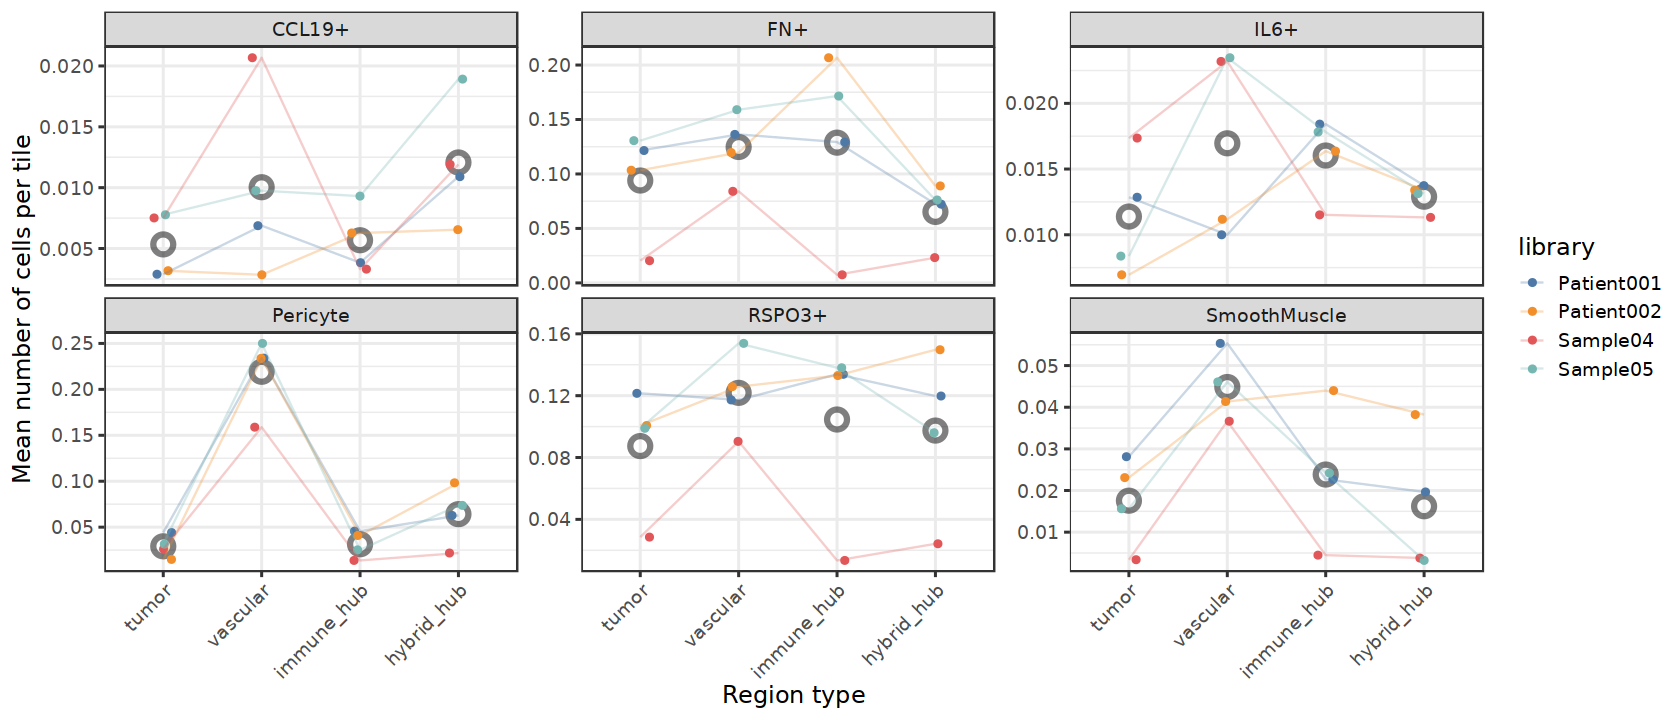

In [21]:
types_show = meta_data %>% 
    filter(type_lvl1 %in% c('Fibroblast', 'SmoothMuscle', 'Pericyte')) %>% 
    with(unique(type_lvl2))

fig.size(6, 14)
df_mean %>% 
    filter(type_lvl2 %in% types_show) %>% 
    ggplot(aes(hubType, mu, color = library)) + 
        geom_point(
            data = df_mean[type_lvl2 %in% types_show, .(mu = mean(mu)), by = .(hubType, type_lvl2)], 
            color = 'black', size = 4, shape = 21, alpha = .5, stroke = 2
        ) + 
        geom_point(position = position_jitter(width = .1, height = 0)) + 
        geom_line(aes(group = library), alpha = .3) + 
        facet_wrap(~type_lvl2, scales = 'free_y', nrow = 2) + 
        theme_bw(base_size = 14) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
        labs(x = 'Region type', y = 'Mean number of cells per tile') + 
        scale_color_tableau() + 
        NULL


### vs-tumor

In [22]:
df_hub = data.table(df)[][
    , .(mu = mean(density)), 
    by = .(hubType, library, type_lvl2, hubID, hubSize_tiles)
]
head(df_hub)

hubType,library,type_lvl2,hubID,hubSize_tiles,mu
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
tumor,Patient001,Epithelial,R686,66,1.5839161
tumor,Patient001,Epithelial,R490,233,0.2618026
vascular,Patient001,Epithelial,R850,296,0.2988329
tumor,Patient001,Epithelial,R642,3676,0.8610809
tumor,Patient001,Epithelial,R521,67,0.2345416
vascular,Patient001,Epithelial,R859,13,0.3241758


In [23]:
res_vs_tumor = map(c('immune_hub', 'hybrid_hub', 'vascular'), function(type) {
    foo <- function(data_df) {
        suppressMessages({
            # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE) #, weights = data_df$hubSize_tiles)
            # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE) #, weights = data_df$hubSize_tiles) 
            h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
            h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
            # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE)
            # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE)              
            # h0 = lmer(mu ~ 1 + (1|library), data_df, REML = FALSE)
            # h1 = lmer(mu ~ 1 + hubType + (1|library), data_df, REML = FALSE)              
        })
        tibble(
            pval = anova(h0, h1)['h1', 'Pr(>Chisq)'], 
            logOR = log2(sum(fixef(h1)) / fixef(h1)[['(Intercept)']]),
            zscore = sign(logOR) * sqrt(anova(h0, h1)['h1', 'Chisq'])
        )
    }

    df_hub[
    ][
        hubType %in% c('tumor', type)
    ][
        , hubType := factor(hubType, c('tumor', type))
    ][
        , foo(.SD), by = type_lvl2
    ][
        order(-logOR)
    ][
        , fdr := p.adjust(pval)
    ][
        , hubType := type
    ][
        , SD := logOR / zscore ## for plotting 
    ][]

}) %>% 
    bind_rows() %>% 
    dplyr::select(hubType, everything())


In [24]:
res_vs_tumor %>% 
    filter(type_lvl2 == 'CCL19+')

hubType,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
immune_hub,CCL19+,0.100318794,0.5843972,1.643310,0.79660304,0.3556220
hybrid_hub,CCL19+,0.001260102,1.5383926,3.224915,0.03489451,0.4770336
vascular,CCL19+,0.083130475,1.2544618,1.732804,1.00000000,0.7239490


In [25]:
res_vs_tumor %>% 
    split(.$hubType) %>% 
    map(dplyr::arrange, -zscore)

hubType,type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hybrid_hub,TCF7+ CD8 T,0.0000452056,2.4080921,4.0791246,0.001627402,0.5903453
hybrid_hub,Treg,0.0002821404,1.9598649,3.6311689,0.009592774,0.5397339
hybrid_hub,TCF7+PD1+ CD8 T,0.0003606030,2.3344734,3.5673549,0.011899899,0.6543990
hybrid_hub,B,0.0007651119,2.5566217,3.3651171,0.024483579,0.7597423
hybrid_hub,CD4 T,0.0008268381,2.6935458,3.3436506,0.025631980,0.8055704
hybrid_hub,PLA2G7+ CCL18+ Macrophage,0.0008944841,1.4096127,3.3217699,0.026834524,0.4243559
hybrid_hub,CXCL13+ CD4 T,0.0008974577,1.6005526,3.3208437,0.026834524,0.4819717
hybrid_hub,CD8 T,0.0012462324,1.1983645,3.2280820,0.034894508,0.3712311
hybrid_hub,CCL19+,0.0012601023,1.5383926,3.2249146,0.034894508,0.4770336


### hub-vs-hub

In [26]:
foo <- function(data_df) {
    suppressMessages({
        h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
        h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE, weights = log(data_df$hubSize_tiles))
        # h0 = lmer(mu ~ 1 + (1|library/hubType), data_df, REML = FALSE)
        # h1 = lmer(mu ~ 1 + hubType + (1|library/hubType), data_df, REML = FALSE)  
    })
    tibble(
        pval = anova(h0, h1)['h1', 'Pr(>Chisq)'], 
        logOR = log2(sum(fixef(h1)) / fixef(h1)[['(Intercept)']]),
        zscore = sign(logOR) * sqrt(anova(h0, h1)['h1', 'Chisq'])
    )
}
bar <- function(lvl_bg, lvl_fg) {
    df_hub[
    ][
        hubType %in% c(lvl_bg, lvl_fg)
    ][
        , hubType := factor(hubType, c(lvl_bg, lvl_fg))
    ][
        , foo(.SD), by = type_lvl2
    ][
        order(-logOR)
    ][
        , fdr := p.adjust(pval)
    ][
        , SD := logOR / zscore ## for plotting 
    ][]
    
}


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


type_lvl2,pval,logOR,zscore,fdr,SD
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCF7+ CD4 T,0.0040731549,2.4020079,2.872440,0.122194646,0.8362256
B,0.0015843102,1.8377576,3.158780,0.053866548,0.5817935
CD4 T,0.0040984838,1.6089696,2.870481,0.122194646,0.5605227
TCF7+PD1+ CD8 T,0.0012229605,1.5596941,3.233470,0.042803619,0.4823592
FOLR2+CD14+ Macrophage,0.0023853972,-0.8441292,-3.037512,0.076332709,0.2779015
SPP1+ Macrophage,0.0033358188,-1.0472545,-2.934968,0.103410384,0.3568197
MMP1+SOX4+ Myeloid,0.0043309958,-1.3531648,-2.852990,0.122194646,0.4742970
MARCO+ Macrophage,0.0020448476,-1.6390639,-3.083640,0.067479970,0.5315354
Epithelial,0.0001410166,-2.1180816,-3.806378,0.005076596,0.5564559


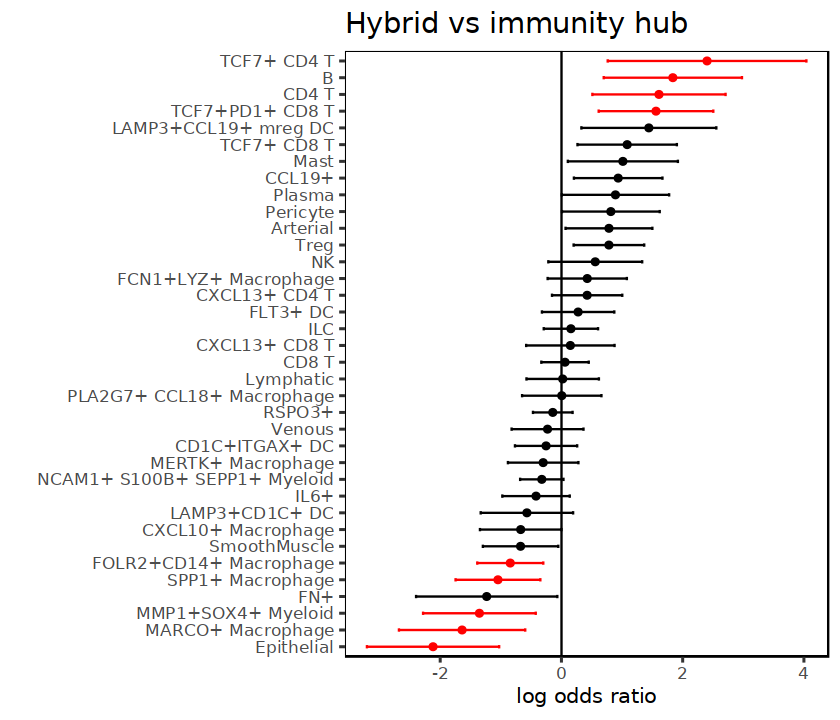

In [27]:
hybrid_vs_immunity = bar('immune_hub', 'hybrid_hub')
hybrid_vs_immunity[fdr < .2]

fig.size(6, 7)
p1 = hybrid_vs_immunity %>% 
    ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
        coord_flip() + 
        geom_hline(yintercept = 0) + 
        scale_color_manual(values = c('black', 'red')) +
        labs(title = 'Hybrid vs immunity hub', y = 'log odds ratio', x = '') + 
        guides(color = 'none') + 
        NULL
p1

In [28]:
# hybrid_vs_tumor = bar('tumor', 'hybrid_hub')
# hybrid_vs_tumor[fdr < .1]

# fig.size(6, 7)
# p2 = hybrid_vs_tumor %>% 
#     ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
#         geom_point() + 
#         geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
#         coord_flip() + 
#         geom_hline(yintercept = 0) + 
#         scale_color_manual(values = c('black', 'red')) +
#         labs(title = 'Hybrid hubs vs tumor', y = 'log odds ratio', x = '') + 
#         guides(color = 'none') + 
#         NULL
# p2

# immune_vs_tumor = bar('tumor', 'immune_hub')
# immune_vs_tumor[fdr < .1]

# fig.size(6, 7)
# p3 = immune_vs_tumor %>% 
#     ggplot(aes(reorder(type_lvl2, logOR), logOR, color = fdr < .2)) + 
#         geom_point() + 
#         geom_errorbar(aes(ymin = logOR - 1.96 * SD, ymax = logOR + 1.96 * SD), width = .2) + 
#         coord_flip() + 
#         geom_hline(yintercept = 0) + 
#         scale_color_manual(values = c('black', 'red')) +
#         labs(title = 'Immunity hubs vs tumor', y = 'log odds ratio', x = '') + 
#         guides(color = 'none') + 
#         NULL
# p3

### Forest plots

## Co-localization inside stem immunity niche

### function

In [29]:
## By default, only keep the mean and SD of permutation distribution
##   If save_perms=TRUE, keep all the values 
bar = function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE, save_perms=FALSE) {
    if (verbose) message(index_type)
    types = unique(y)
    i_index = which(y == index_type)
    i_shuffle = setdiff(seq_len(length(y)), i_index)

    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix() 
    colnames(X) = gsub('^y', '', colnames(X))
    freq = (colSums(X) / nrow(X))[types]
    freq_perm = map(seq_len(nperm), function(i) {
        set.seed(i)
        yperm = y
        if (is.null(compartments)) {
            yperm[i_shuffle] = sample(y[i_shuffle])
        } else {
            ## shuffle inside compartments, to preserve total composition within compartment
            .x = split(i_shuffle, compartments[i_shuffle]) %>% 
                map(function(.i) {
                    ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
                    if (length(.i) == 1) {
                        res = .i
                    } else {
                        res = sample(.i) ## shuffle non-index cells inside hub             
                    }
                    
                    names(res) = .i
                    return(res)
                }) %>% 
                reduce(c)
            yperm[as.integer(names(.x))] <- y[.x]
        }

        X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
        colnames(X) = gsub('^yperm', '', colnames(X))
        (colSums(X) / nrow(X))[types]    
    }) %>% 
        purrr::reduce(rbind2)

    stats = tibble(
        type = types, 
        freq, 
        zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd), 
        pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
        fdr = p.adjust(pval)
    ) %>% 
        cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI
        subset(type != index_type) %>% 
        dplyr::mutate(index_type = index_type) %>% 
        dplyr::select(index_type, type, everything()) %>% 
        arrange(fdr)
    
    if (save_perms) {
        stats$freq_perm = asplit(freq_perm[, stats$type, drop = FALSE], 2)
    }

    return(stats)    
}
foo = function(index_types, coords, y, nperm = 100, max_dist=30, compartments=NULL, parallel=TRUE, verbose=TRUE, save_perms=FALSE) {
    if (parallel & length(index_types) > 1) {
        plan(multicore)
    } else {
        plan(sequential)
    }

    adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)
    adj@x[adj@x > max_dist] = 0
    adj = Matrix::drop0(adj)
    adj@x = rep(1, length(adj@x))
    
    ## map over index types 
    index_types %>% 
        future_map(bar, adj, y, nperm, max_dist, compartments, verbose, save_perms, .options = furrr::furrr_options(seed = 1)) %>% 
        rbindlist()  
}


### meta-analysis over libraries and hub types

#### Compute stats

In [30]:
# .SD = cells$meta_data[
#     library %in% 'Patient001' & 
#     type_lvl2 %in% c('B', 'Treg', 'CD8 T') #, 'NK', 'CD4 T', 'CD8 T')
# ][
#     type_lvl2 != '' & hubType == 'hybrid_hub'
# ]

In [31]:
# foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = NULL, parallel = FALSE, verbose = TRUE)

Might take ~1 hour? 

In [32]:
system.time({
    # res = cells$meta_data[
    res = meta_data[
        ## SUBSET FOR TESTING 
        # library %in% c('Patient001') & 
        # type_lvl2 %in% c('B', 'Treg', 'LAMP3+CCL19+ mreg DC') #, 'NK', 'CD4 T', 'CD8 T')
        # type_lvl2 %in% c('Epithelial', 'SPP1+ Macrophage', 'MMP1+SOX4+ Myeloid')
    ][
        # type_lvl2 != '' & hubType %in% c('hybrid_hub')
        # type_lvl2 != '' ## do all hub types! 
        type_lvl2 != '' & hubType %in% c('hybrid_hub', 'immune_hub')
    ][
        # , unique(.SD[, hubID]), 
        , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 1000, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE, save_perms = TRUE), 
        # , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 20, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE, save_perms = TRUE), 
        # , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 20, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE), 
        # , foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = NULL, parallel = TRUE, verbose = TRUE), 
        # , foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = .SD, parallel = FALSE, verbose = TRUE), 
        by = .(library, hubType)
    ]
})


Epithelial

RSPO3+

LAMP3+CCL19+ mreg DC

Plasma

FN+

SPP1+ Macrophage

ILC

Mast

FOLR2+CD14+ Macrophage

CD1C+ITGAX+ DC

MARCO+ Macrophage

CD8 T

Treg

Pericyte

MMP1+SOX4+ Myeloid

MERTK+ Macrophage

IL6+

LAMP3+CD1C+ DC

CD4 T

TCF7+ CD8 T

Arterial

CXCL10+ Macrophage

FLT3+ DC

CXCL13+ CD4 T

TCF7+PD1+ CD8 T

PLA2G7+ CCL18+ Macrophage

FCN1+LYZ+ Macrophage

NCAM1+ S100B+ SEPP1+ Myeloid

B

Venous

TCF7+ CD4 T

Lymphatic

SmoothMuscle

CXCL13+ CD8 T

CCL19+

NK

Epithelial

RSPO3+

CD4 T

Treg

FN+

B

MERTK+ Macrophage

Pericyte

SPP1+ Macrophage

Arterial

CD8 T

FCN1+LYZ+ Macrophage

TCF7+ CD4 T

Venous

Plasma

ILC

CD1C+ITGAX+ DC

FOLR2+CD14+ Macrophage

LAMP3+CCL19+ mreg DC

NK

Mast

CXCL13+ CD8 T

CXCL13+ CD4 T

TCF7+ CD8 T

Lymphatic

MARCO+ Macrophage

LAMP3+CD1C+ DC

FLT3+ DC

NCAM1+ S100B+ SEPP1+ Myeloid

CXCL10+ Macrophage

TCF7+PD1+ CD8 T

IL6+

MMP1+SOX4+ Myeloid

SmoothMuscle

CCL19+

PLA2G7+ CCL18+ Macrophage

Epithelial

FN+

ILC

MARCO+ Macrophage

FCN1+LYZ+ M

     user    system   elapsed 
21652.109   617.661  2612.709 

In [33]:
pryr::object_size(res)


84.27 MB

In [34]:
res %>% map(pryr::object_size)

$library
80.94 kB

$hubType
80.82 kB

$index_type
83.05 kB

$type
83.05 kB

$freq
80.69 kB

$zscore
80.69 kB

$pval
80.69 kB

$fdr
80.69 kB

$q025
80.69 kB

$q975
80.69 kB

$freq_perm
83.46 MB


#### Cache

In [35]:
fwrite(res, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats_revision.csv')

In [7]:
res = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats_revision.csv')
library(stringr)
if ('freq_perm' %in% colnames(res)) {
    res$freq_perm = res$freq_perm %>% str_split('\\|') %>% map(as.numeric)    
}


In [18]:
# res[index_type == 'IL6+'][hubType == 'hybrid_hub'][, .(zscore = mean(zscore)), by = type][order(-zscore)]
# res[index_type == 'IL6+'][hubType == 'immune_hub'][, .(zscore = mean(zscore)), by = type][order(-zscore)]
# res[index_type == 'CCL19+'][hubType == 'hybrid_hub'][, .(zscore = mean(zscore)), by = type][order(-zscore)]
# res[index_type == 'IL6+'][hubType == 'hybrid_hub'][, .(zscore = mean(zscore)), by = type][order(-zscore)]


#### Histograms

In [37]:
# fig.size(5, 7)
# res[hubType == 'immune_hub' & grepl('CXCL10', index_type) & grepl('^CD4 T', type)] %>% 
# # res[hubType == 'immune_hub' & grepl('CXCL10', index_type) & grepl('^CD8 T', type)] %>% 
#     asplit(1) %>% 
#     map(function(.SD) {
#         ggplot() + 
#             geom_histogram(
#                 data = tibble(x = .SD$freq_perm), 
#                 aes(x)
#             ) + 
#             geom_vline(
#                 data = tibble(x = .SD$freq), aes(xintercept = x), color = 'red'
#             ) + 
#             labs(
#                 title = 'Permutation Distribution', subtitle = .SD$library, 
#                 x = glue('#{.SD$type} near a {.SD$index_type}')
#             ) + 
#             theme_bw(base_size = 14) + 
#             NULL
#     }) 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

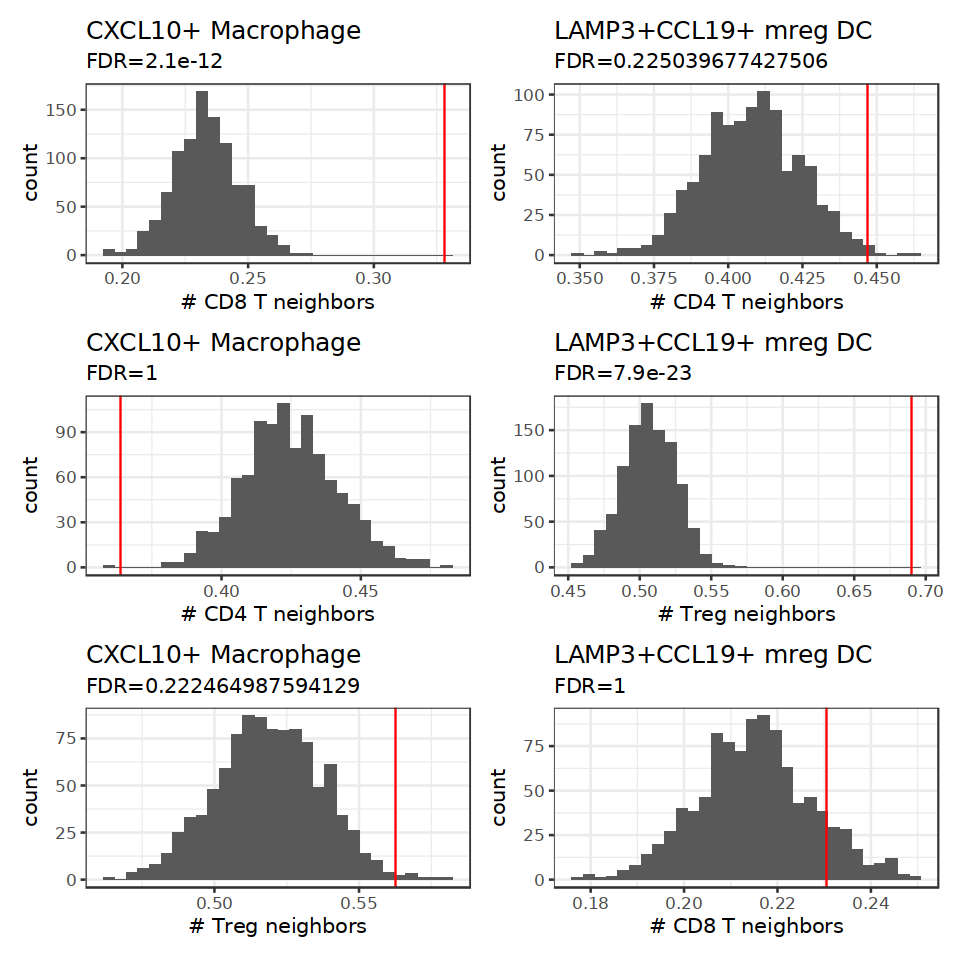

In [36]:
foo = function(t1, t2) {
    .SD = res[hubType == 'hybrid_hub' & library == 'Patient001' & index_type == t1 & type == t2] 
    if (.SD$fdr < .001) {
        .subtitle = glue('FDR={base::format(.SD$fdr, scientific=TRUE, digits=2)}')
    } else {
        .subtitle = glue('FDR={.SD$fdr}')
    }
    
    ggplot() + 
        geom_histogram(
            data = tibble(x = unlist(.SD$freq_perm)), 
            aes(x)
        ) + 
        geom_vline(
            data = tibble(x = .SD$freq), aes(xintercept = x), color = 'red'
        ) + 
        labs(
            # title = 'Permutation Distribution', subtitle = .SD$library, 
            title = glue('{.SD$index_type}'), 
            subtitle = .subtitle, 
            x = glue('# {.SD$type} neighbors')
            # x = glue('#{.SD$type} near a {.SD$index_type}')
        ) + 
        # scale_x_log10() + 
        theme_bw(base_size = 12) + 
        NULL
}

fig.size(8, 8)
(
    (
        foo('CXCL10+ Macrophage', 'CD8 T') /
        foo('CXCL10+ Macrophage', 'CD4 T') / 
        foo('CXCL10+ Macrophage', 'Treg') 
    ) 
) | 
(
    foo('LAMP3+CCL19+ mreg DC', 'CD4 T') / 
    foo('LAMP3+CCL19+ mreg DC', 'Treg') / 
    foo('LAMP3+CCL19+ mreg DC', 'CD8 T')
) + 
plot_annotation(tag_levels = 'a')

ggsave('figures/Null_distributions.pdf', device = 'pdf', units = 'in', height = 8, width = 8)
ggsave('figures/Null_distributions.png', device = 'png', units = 'in', height = 8, width = 8)


In [117]:
# fig.size(8, 8)
# t1 = 'LAMP3+CCL19+ mreg DC'
# t2 = 'Treg'
# .SD = res[hubType == 'hybrid_hub' & index_type == t1 & type == t2] 
# .SD %>% 
#     asplit(1) %>% 
#     imap(function(x, name) {
#         ggplot() + 
#             geom_histogram(
#                 data = tibble(x = unlist(x$freq_perm)), 
#                 aes(x)
#             ) + 
#             geom_vline(
#                 data = tibble(x = x$freq), aes(xintercept = x), color = 'red'
#             ) + 
#             labs(
#                 # title = 'Permutation Distribution', subtitle = .SD$library, 
#                 subtitle = glue('{.SD$index_type}'), 
#                 x = glue('# {.SD$type} neighbors')
#                 # x = glue('#{.SD$type} near a {.SD$index_type}')
#             ) + 
#             # scale_x_log10() + 
#             theme_bw(base_size = 12) + 
#             NULL
#     }) %>% 
#     reduce(`+`)


In [116]:
# fig.size(5, 8)
# .SD %>% 
#     tidyr::unnest(freq_perm) %>% 
#     ggplot() + 
#         geom_density(aes(freq_perm, fill = library)) + 
#         # geom_histogram(aes(freq_perm, fill = library)) + 
#         geom_vline(aes(xintercept = freq, color = library)) + 
#         scale_fill_tableau() + 
#         scale_color_tableau() + 
#         NULL


In [20]:
libs = unique(res$library)
for (lib in libs) {
    lib <<- lib
    foo = function(t1, t2) {
        .SD = res[hubType == 'hybrid_hub' & library == lib & index_type == t1 & type == t2] 
        if (.SD$fdr < .01) {
            .subtitle = glue('FDR={base::format(.SD$fdr, scientific=TRUE, digits=2)}')
        } else {
            .subtitle = glue('FDR={base::format(.SD$fdr, digits=2)}')
        }
        ggplot() + 
            geom_histogram(
                data = tibble(x = unlist(.SD$freq_perm)), 
                aes(x), 
                bins = 30
            ) + 
            geom_vline(
                data = tibble(x = .SD$freq), aes(xintercept = x), color = 'red'
            ) + 
            labs(
                # title = 'Permutation Distribution', subtitle = .SD$library, 
                # subtitle = glue('{.SD$index_type}'), 
                title = glue('{.SD$index_type}'), 
                subtitle = .subtitle, 
                x = glue('# {.SD$type} neighbors')
                # x = glue('#{.SD$type} near a {.SD$index_type}')
            ) + 
            # scale_x_log10() + 
            theme_bw(base_size = 12) + 
            NULL
    }

    fig.size(8, 8)
    (
        (
            foo('CXCL10+ Macrophage', 'CD8 T') /
            foo('CXCL10+ Macrophage', 'CD4 T') / 
            foo('CXCL10+ Macrophage', 'Treg') 
        ) 
    ) | 
    (
        foo('LAMP3+CCL19+ mreg DC', 'CD4 T') / 
        foo('LAMP3+CCL19+ mreg DC', 'Treg') / 
        foo('LAMP3+CCL19+ mreg DC', 'CD8 T')
    ) + 
    plot_annotation(tag_levels = 'a')

    ggsave(glue('figures/Null_distributions_{lib}.pdf'), device = 'pdf', units = 'in', height = 8, width = 8)
    ggsave(glue('figures/Null_distributions_{lib}.png'), device = 'png', units = 'in', height = 8, width = 8)

}


#### Heatmaps

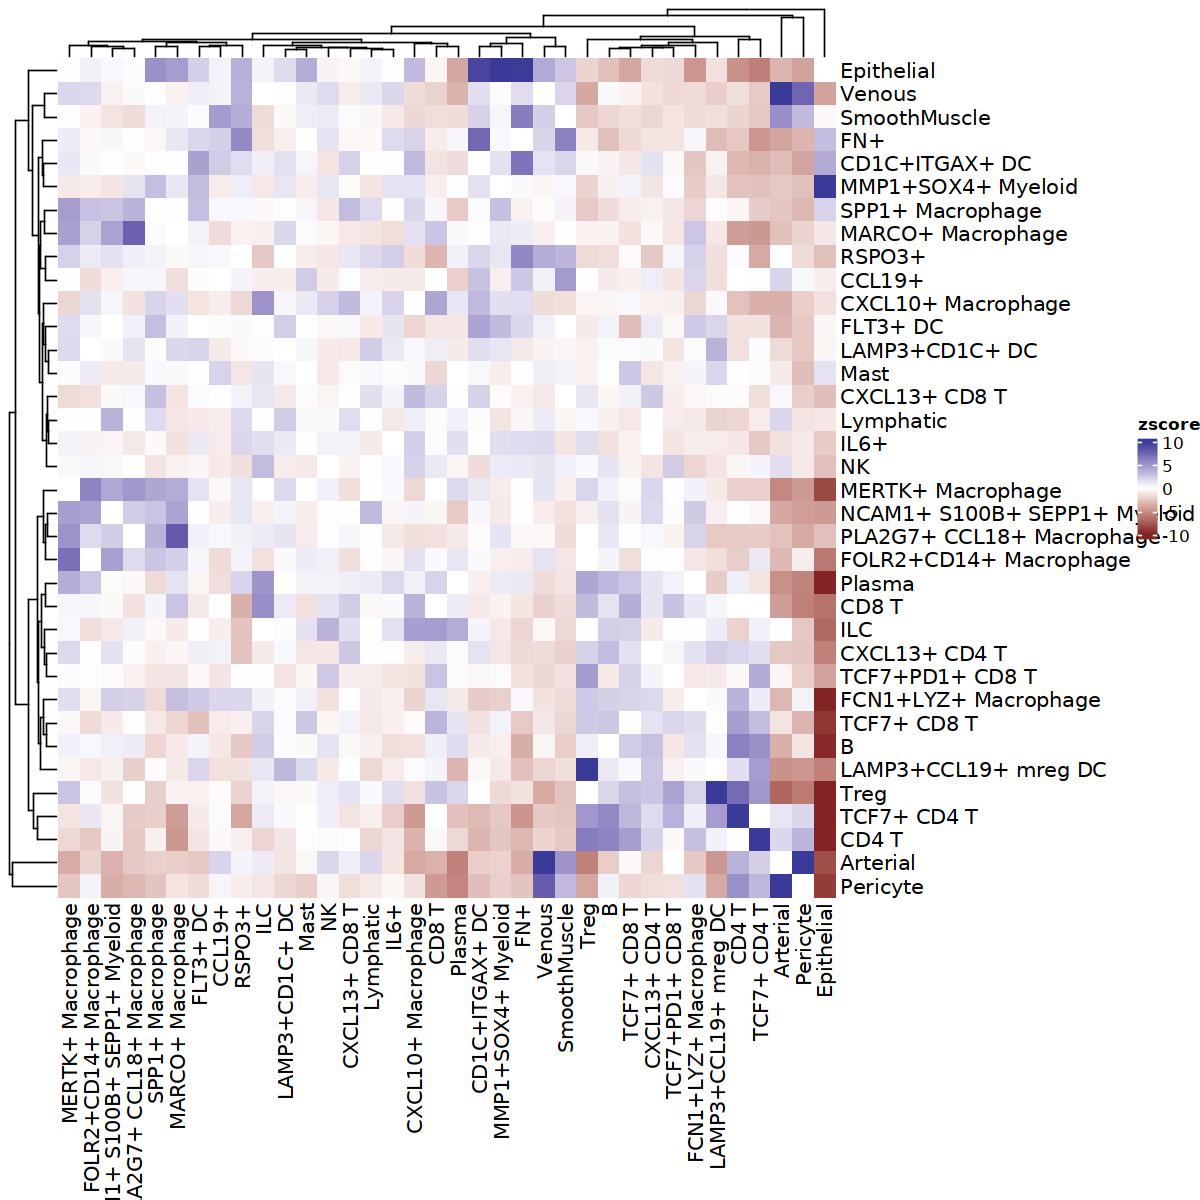

In [37]:
fig.size(10, 10)
X = res[library == 'Patient002' & hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
# X = res[library == 'Patient002' & hubType == 'immune_hub'][, .(index_type, type, zscore)] %>%
# X = res[library == 'Patient001' & hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = 0) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

Heatmap(
    matrix = X, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c(muted('red'), 'white', muted('blue'))),
    column_title = ''
    # col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue')))        
    # col = colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue')))        
)


#### Summarize stats

Interesting things: 
- Sample04 seems really off: we may have misclassified hubs in this dataset 
- Tregs are next to CXCL10+ macs in immunity hubs but not in hybrid hubs


In [109]:
# writeLines(sort(unique(res$type)))

In [125]:
# meta_data[, .N, by = .(hubType, type_lvl2, library)][, Ntot := sum(N), by = .(hubType, type_lvl2)][, w := N/Ntot][, .(hubType, index_type = type_lvl2, library, w)]


In [112]:
res_meta = left_join(
    res, 
    meta_data[, .N, by = .(hubType, type_lvl2, library)][, Ntot := sum(N), by = .(hubType, type_lvl2)][, w := N/Ntot][, .(hubType, index_type = type_lvl2, library, w)]
)[
    , .(freq = sum(w*freq)/sqrt(sum(w^2)), zscore = sum(w*zscore)/sqrt(sum(w^2))), 
    # , .(freq = mean(freq), zscore = mean(zscore)), 
    , by = .(index_type, type, hubType)
][
    , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed    
][
    , fdr := p.adjust(pval)
][]

Joining with `by = join_by(library, hubType, index_type)`


In [118]:
res_meta %>% 
    filter(hubType == 'hybrid_hub') %>% 
    filter(index_type == 'CCL19+') %>% 
    filter(fdr < .05) %>% 
    arrange(fdr)

res_meta %>% 
    filter(hubType == 'hybrid_hub') %>% 
    filter(index_type == 'LAMP3+CCL19+ mreg DC') %>% 
    filter(fdr < .01) %>% 
    arrange(fdr)



index_type,type,hubType,freq,zscore,pval,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CCL19+,Arterial,hybrid_hub,0.3939864,8.425010,1.803598e-17,3.782145e-14
CCL19+,CD4 T,hybrid_hub,1.2809826,7.531581,2.506477e-14,5.170862e-11
CCL19+,Pericyte,hybrid_hub,0.3413144,7.492690,3.373809e-14,6.953421e-11
CCL19+,Venous,hybrid_hub,0.5814987,6.700998,1.035005e-11,2.102096e-08
CCL19+,B,hybrid_hub,0.5456817,5.387619,3.569862e-08,6.950522e-05


index_type,type,hubType,freq,zscore,pval,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
LAMP3+CCL19+ mreg DC,Treg,hybrid_hub,1.05019455,12.464139,5.856527e-36,1.274966e-32
LAMP3+CCL19+ mreg DC,CD4 T,hybrid_hub,1.33096636,10.966364,2.772901e-28,5.958965e-25
LAMP3+CCL19+ mreg DC,B,hybrid_hub,0.47839196,6.825201,4.390126e-12,8.951466e-09
LAMP3+CCL19+ mreg DC,LAMP3+CD1C+ DC,hybrid_hub,0.08153181,5.971416,1.176017e-09,2.337922e-06
LAMP3+CCL19+ mreg DC,FLT3+ DC,hybrid_hub,0.11500845,5.339173,4.668576e-08,9.075711e-05
LAMP3+CCL19+ mreg DC,CXCL10+ Macrophage,hybrid_hub,0.33044682,4.467993,3.947839e-06,7.358771e-03


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


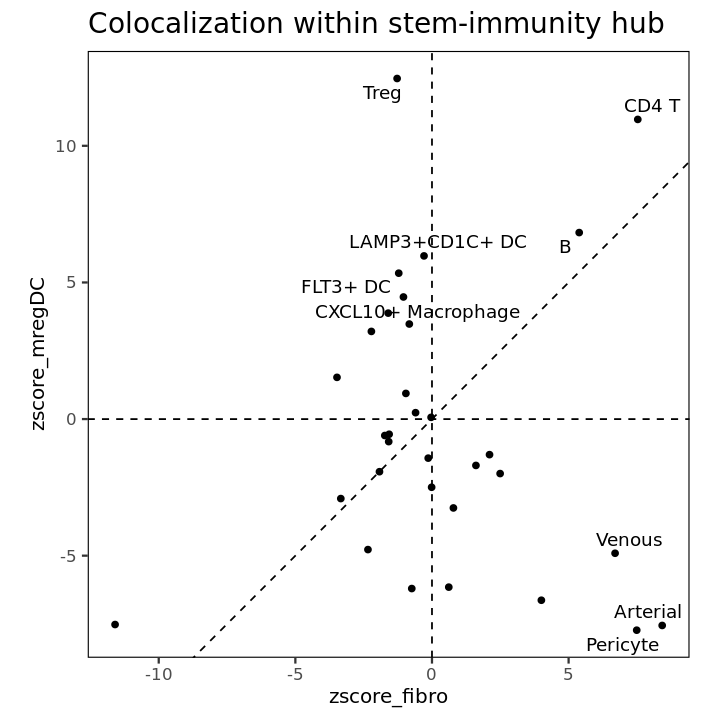

In [143]:
fig.size(6, 6)
full_join(
    res_meta %>% 
        filter(hubType == 'hybrid_hub') %>% 
        filter(index_type == 'CCL19+'),
    res_meta %>% 
        filter(hubType == 'hybrid_hub') %>% 
        filter(index_type == 'LAMP3+CCL19+ mreg DC'),
    by = c('type', 'hubType'),
    suffix = c('_fibro', '_mregDC')
) %>% 
    ggplot(aes(zscore_fibro, zscore_mregDC)) + 
        geom_point() + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_abline(linetype = 2) + 
        geom_text_repel(
            data = . %>% filter(fdr_fibro < .05 | fdr_mregDC < .05), 
            aes(label = type)
        ) + 
        coord_fixed() + 
        labs(title = 'Colocalization within stem-immunity hub') + 
        NULL


In [264]:
# res_meta = res[
#     , .(freq = mean(freq), zscore = mean(zscore)), 
#     , by = .(index_type, type, hubType)
# ][
#     , pval := 2 * exp(pnorm(-abs(zscore), log.p = TRUE, lower.tail = TRUE)), ## two-tailed    
#     # , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed    
# ][
#     , fdr := p.adjust(pval)
# ][]

# head(res_meta)
res_meta = left_join(
    res, 
    meta_all[, .N, by = .(hubType, type_lvl2, library)][, Ntot := sum(N), by = .(hubType, type_lvl2)][, w := N/Ntot][, .(hubType, index_type = type_lvl2, library, w)]
    # meta_data[type == 'spatial'][, .N, by = .(hubType, type_lvl2, library)][, Ntot := sum(N), by = .(hubType, type_lvl2)][, w := N/Ntot][, .(hubType, index_type = type_lvl2, library, w)]
)[
    hubType == 'stem_immunity'
][
    , .(freq = sum(w*freq)/sqrt(sum(w^2)), zscore = sum(w*zscore)/sqrt(sum(w^2))), 
    # , .(freq = mean(freq), zscore = mean(zscore)), 
    , by = .(index_type, type, hubType)
][
    , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed    
][
    , fdr := p.adjust(pval)
][]


Joining with `by = join_by(library, hubType, index_type)`


In [32]:
# res_meta[index_type == 'LAMP3+CCL19+ mreg DC'][order(-zscore)] %>% split(.$hubType) %>% map(head)

In [33]:
res_meta[index_type == 'CCL19+'][order(-zscore)] %>% split(.$hubType) %>% map(head)

,index_type,type,hubType,freq,zscore,pval,fdr
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,CCL19+,Arterial,hybrid_hub,0.2269785,4.103264,2.036808e-05,0.04269149
2,CCL19+,Pericyte,hybrid_hub,0.1944952,3.408247,3.269081e-04,0.66525801
3,CCL19+,CD4 T,hybrid_hub,0.6938136,3.281587,5.161243e-04,1.00000000
4,CCL19+,Venous,hybrid_hub,0.3135783,3.006305,1.322220e-03,1.00000000
5,CCL19+,B,hybrid_hub,0.2482855,1.985801,2.352774e-02,1.00000000
6,CCL19+,RSPO3+,hybrid_hub,0.2413612,1.923387,2.721572e-02,1.00000000
,index_type,type,hubType,freq,zscore,pval,fdr
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,CCL19+,CD4 T,immune_hub,0.15699116,2.719427,0.003269752,1


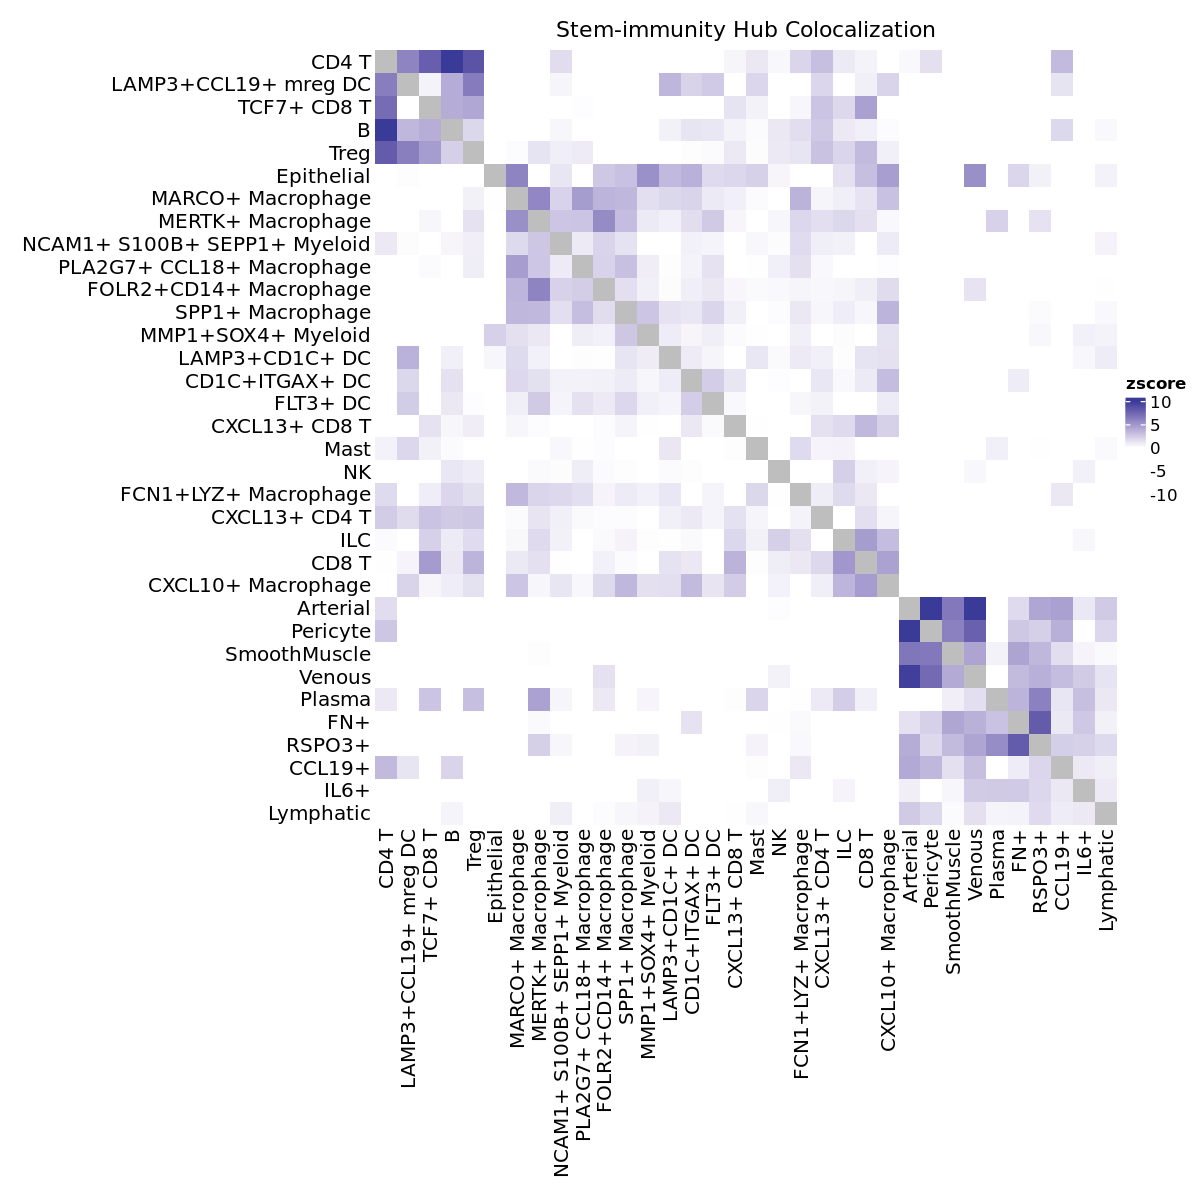

In [23]:
fig.size(10, 10)
X = res_meta[hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = NA) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

X = pmin(X, 10)
o = hclust(dist(X))$order

plt = Heatmap(
    matrix = X[o, o], 
    cluster_columns = FALSE, cluster_rows = FALSE, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue'))),
    column_title = 'Stem-immunity Hub Colocalization',
    row_names_side = 'left'
)

plt <- grid.grabExpr(
    draw(
        plt, 
        padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
    )    
) 
plt <- wrap_elements(plt)
plt


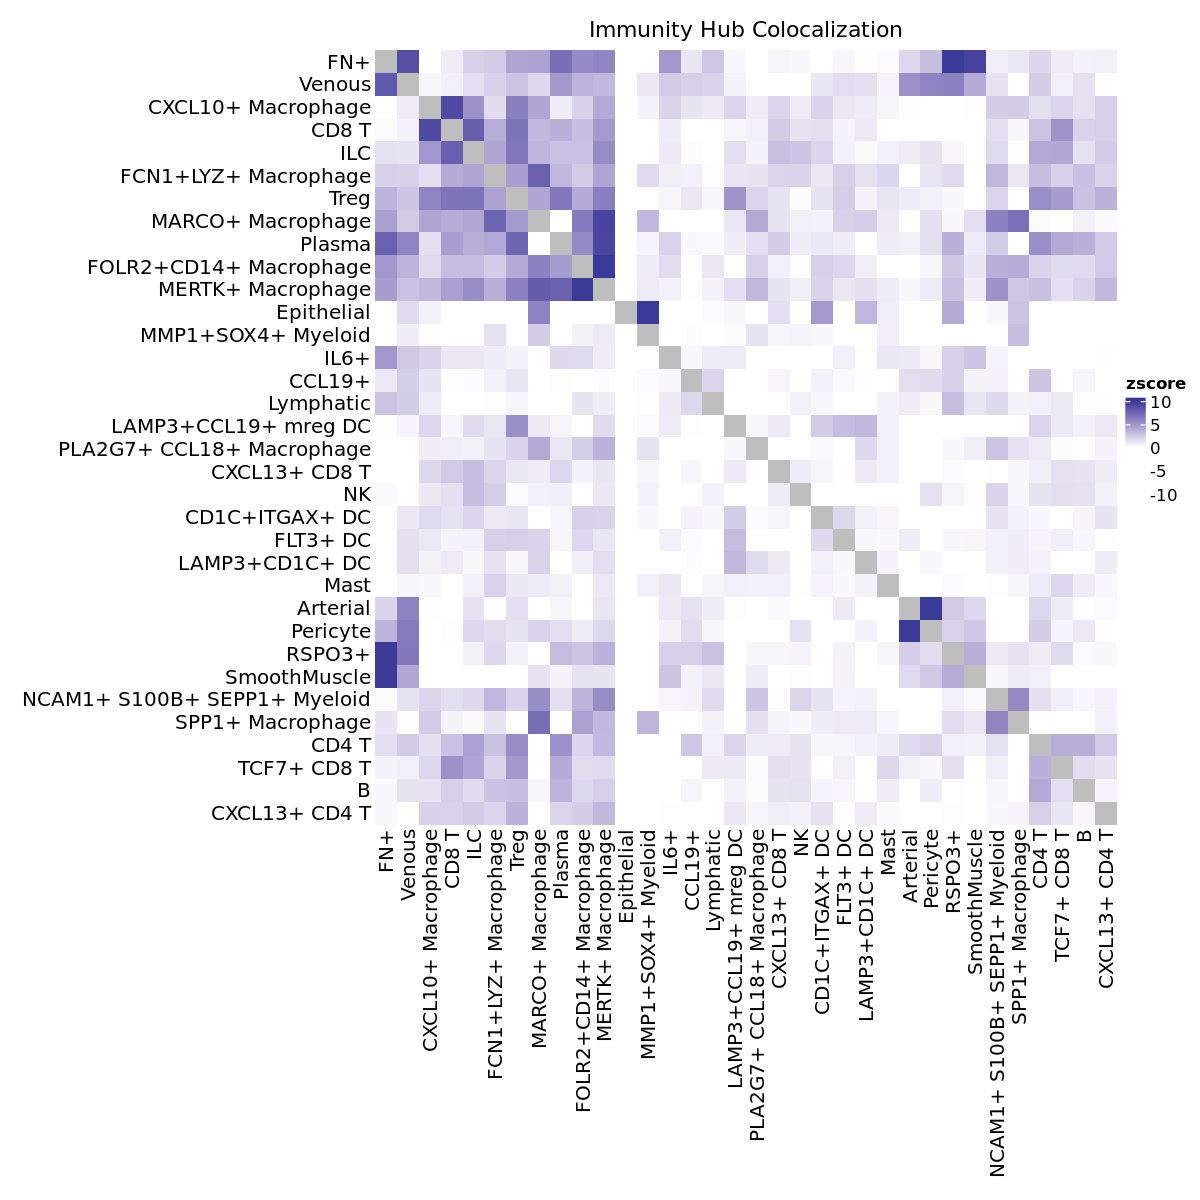

In [24]:
fig.size(10, 10)
X = res_meta[hubType == 'immune_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = NA) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

X = pmin(X, 10)
o = hclust(dist(X))$order

plt = Heatmap(
    matrix = X[o, o], 
    cluster_columns = FALSE, cluster_rows = FALSE, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue'))),
    column_title = 'Immunity Hub Colocalization',
    row_names_side = 'left'
)

plt <- grid.grabExpr(
    draw(
        plt, 
        padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
    )    
) 
plt <- wrap_elements(plt)
plt


# Figures

## Data

In [77]:
meta_data = fread('../data/stromal_fine_types.csv') %>% 
    left_join(
        ## add spatial info 
        fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/cells/meta_data.csv') %>% 
        # fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv') %>% 
            dplyr::mutate(cell = as.character(cell)) %>% 
            dplyr::select(cell, hubID),
        by = 'cell'
    ) %>%
    left_join(
        unique(fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/tiles/meta_data.csv')[, .(hubID = paste0('R', hubID), hubSize_ntiles, hubSize_um2, hubType)]), 
        by = 'hubID'
    ) %>% 
    dplyr::mutate(
        ## messy, copying variable, but needed for functions
        library = batch,
        hubSize_tiles = hubSize_ntiles
    ) 

markers_ref = fread('../data/stromal_fine_type_markers_sc.csv')
markers_spa = fread('../data/stromal_fine_type_markers_spatial_all.csv')
# markers_spa = fread('../data/stromal_fine_type_markers_spatial.csv')
types = c('', 'Venous', 'FN+', 'Arterial', 'RSPO3+', 'Pericyte', 'IL6+', 'SmoothMuscle', 'Lymphatic', 'CCL19+')
types_nice = c('', 'Venous EC', 'FN1+ Fibroblast', 'Arterial EC', 'RSPO3+ Fibroblast', 'Pericyte', 'IL6+ Fibroblast', 'SmoothMuscle', 'Lymphatic EC', 'CCL19+ Fibroblast')
o = match(meta_data$type_lvl2, types)
meta_data$type_lvl2 = types_nice[o]

o = match(markers_ref$cluster, types)
markers_ref$cluster = types_nice[o]
o = match(markers_spa$cluster, types)
markers_spa$cluster = types_nice[o]


types = c('hybrid_hub', 'immune_hub', 'tumor', 'vascular')
types_nice = c('stem_immunity', 'activated_immunity', 'tumor', 'vascular')
o = match(meta_data$hubType, types)
meta_data$hubType = types_nice[o]


In [82]:
head(fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/cells/meta_data.csv'))

cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2,UMAP1_all,UMAP2_all,UMAP1_immune,UMAP2_immune
<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial,0.6343959,0.154633419,NA,NA
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,tumor,Lymphocyte,B,-1.5597103,0.002063452,0.6360152,0.5448408
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,tumor,Epithelial,Epithelial,0.8468631,0.231922747,NA,NA
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,tumor,Epithelial,Epithelial,1.0996897,0.321722211,NA,NA
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,tumor,Epithelial,Epithelial,0.9649788,0.678280176,NA,NA
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,tumor,Epithelial,Epithelial,1.0787352,0.278981359,NA,NA


In [85]:
## All spatial cells, not just stromal
meta_all = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/cells/meta_data.csv') %>% 
    dplyr::mutate(cell = as.character(cell)) %>% 
#     left_join(
#         unique(fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/tiles/meta_data.csv')[, .(hubID = paste0('R', hubID), hubSize_ntiles, hubSize_um2, hubType)]), 
#         by = 'hubID'
#     )
# %>% 
#     filter(hubType == 'hybrid_hub') %>% 
    identity()

meta_all = meta_all %>% 
    left_join(unique(meta_data[, .(cell, type_lvl2_new = type_lvl2)])) %>% 
    dplyr::mutate(type_lvl2 = case_when(
        type_lvl1 %in% c('Vascular', 'Fibroblast') ~ type_lvl2_new, 
        TRUE ~ type_lvl2
    ))

types = c('hybrid_hub', 'immune_hub', 'tumor', 'vascular')
types_nice = c('stem_immunity', 'activated_immunity', 'tumor', 'vascular')
o = match(meta_all$hubType, types)
meta_all$hubType = types_nice[o]


Joining with `by = join_by(cell)`


In [86]:
head(unique(meta_data$hubID))


[1] "R490" "R686" "R850" "R642" "R521" "R404"

In [89]:
head(meta_data)
head(meta_all)


cell,type,batch,seurat_clusters,type_lvl1,type_lvl2,HUMAP_1,HUMAP_2,hubID,hubSize_ntiles,hubSize_um2,hubType,library,hubSize_tiles
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>
31,spatial,Patient001,6,Fibroblast,,-2.161101,-2.064576645,R490,1,2500.000,vascular,Patient001,1
61,spatial,Patient001,5,Endothelial,,5.902034,0.005224887,R686,2,5000.001,activated_immunity,Patient001,2
66,spatial,Patient001,3,Endothelial,Venous EC,7.192262,-2.228913803,R686,2,5000.001,activated_immunity,Patient001,2
78,spatial,Patient001,1,Fibroblast,FN1+ Fibroblast,-4.677952,-0.951800247,R686,2,5000.001,activated_immunity,Patient001,2
106,spatial,Patient001,4,Endothelial,Arterial EC,8.327130,0.892030875,R850,7,15543.627,stem_immunity,Patient001,7
111,spatial,Patient001,0,Fibroblast,RSPO3+ Fibroblast,-4.820428,-5.137191792,R850,7,15543.627,stem_immunity,Patient001,7


cell,library,X,Y,ntx,ngene,nblank,hubID,hubSize_tiles,hubSize_um2,hubType,type_lvl1,type_lvl2,UMAP1_all,UMAP2_all,UMAP1_immune,UMAP2_immune,type_lvl2_new
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Patient001,7086.414,79.414864,30,23,0,R686,66,165000,tumor,Epithelial,Epithelial,0.6343959,0.154633419,NA,NA,NA
2,Patient001,7090.282,-74.397942,16,14,0,R490,233,542538,tumor,Lymphocyte,B,-1.5597103,0.002063452,0.6360152,0.5448408,NA
3,Patient001,7087.515,-21.805606,15,12,1,R490,233,542538,tumor,Epithelial,Epithelial,0.8468631,0.231922747,NA,NA,NA
4,Patient001,7099.331,-17.703966,29,20,0,R490,233,542538,tumor,Epithelial,Epithelial,1.0996897,0.321722211,NA,NA,NA
5,Patient001,7100.477,-9.060024,29,16,1,R490,233,542538,tumor,Epithelial,Epithelial,0.9649788,0.678280176,NA,NA,NA
6,Patient001,7093.215,-5.783358,31,22,0,R490,233,542538,tumor,Epithelial,Epithelial,1.0787352,0.278981359,NA,NA,NA


In [43]:
counts = readRDS('../data/stromal_counts.rds')

In [44]:
# coloc_res = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats_revision.csv')
# library(stringr)
# if ('freq_perm' %in% colnames(coloc_res)) {
#     coloc_res$freq_perm = coloc_res$freq_perm %>% str_split('\\|') %>% map(as.numeric)    
# }


## Functions

In [45]:
do_scatter <- function (umap_use, meta_data, label_name, facet_var, no_guides = TRUE, 
    do_labels = TRUE, nice_names, palette_use = colors_overload, 
    pt_size = 4, point_size = 0.5, pt_shape = ".", base_size = 20, 
    do_points = TRUE, do_density = FALSE, h = 3, w = 4, 
                        alpha_fore=1, alpha_back=.3, color_back='lightgrey', 
                       nrow = 1, do_raster = FALSE, empty_theme=FALSE) 
{
    if (do_raster) {
        geom_point_fxn <- function(...) geom_point_rast(..., width = w, height = h)
    } else {
        geom_point_fxn <- geom_point
    }
    
    plt_df <- data.frame(umap_use)[, 1:2]
    colnames(plt_df) <- c('X1', 'X2')
    plt_df <- plt_df %>% 
        cbind(meta_data) %>% 
        dplyr::sample_frac(1L)
    plt_df$given_name <- plt_df[[label_name]]
    if (!missing(nice_names)) {
        plt_df %<>% dplyr::inner_join(nice_names, by = "given_name") %>% 
            subset(nice_name != "" & !is.na(nice_name))
        plt_df[[label_name]] <- plt_df$nice_name
    }
    
    plt <- plt_df %>% ggplot(aes_string("X1", "X2", col = label_name, 
        fill = label_name)) + 
#         theme_tufte(base_size = base_size) + 
#         theme(panel.background = element_rect(fill = NA, color = "black")) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, 
            alpha = 1, shape = 16, size = 4)), alpha = 'none') + 
        scale_color_manual(values = palette_use) + scale_fill_manual(values = palette_use) + 
        theme(plot.title = element_text(hjust = 0.5)) + labs(x = "UMAP 1", 
        y = "UMAP 2")
    if (do_points) {
        ## this facets while keeping non-facet points in the background
        if (!missing(facet_var)) {
            if (!is(facet_var, 'quosure')) {
                stop('facet_var must be a quosure. e.g. quo(\'donor\')')
            }            

            plt <- plt + geom_point_fxn(
                data = dplyr::select(plt_df, -!!facet_var), 
                shape = pt_shape, size = point_size,
                color = color_back, fill = color_back, alpha = alpha_back
            ) +
                facet_wrap(vars(!!facet_var), nrow = nrow)
        }
        plt <- plt + geom_point_fxn(shape = pt_shape, size = point_size, alpha = alpha_fore)
    }
    if (do_density) 
        plt <- plt + geom_density_2d()
    if (no_guides) 
        plt <- plt + guides(col = 'none', fill = 'none', alpha = 'none')
    if (do_labels) {
        plt <- plt + 
#             geom_text_repel(
#                 data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], 
#                 label.size = NA, aes_string(label = label_name), 
#                 color = "black", 
#                 size = pt_size, alpha = 1, segment.size = 0
#             ) + 
            geom_label(
                data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], 
                aes_string(label = label_name, color = label_name), 
#                 color = "black", 
                fill = 'white', 
                size = pt_size, alpha = .6
            ) + 
            geom_text(
                data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = label_name], 
                # aes_string(label = label_name, color = label_name), 
#                 color = "black", 
                aes_string(label = label_name), color = 'black', 
                size = pt_size, alpha = 1
            ) + 
            guides(col = 'none', fill = 'none')
    }
    if (empty_theme) {
        plt <- plt + theme_void()
    }
    return(plt)
}


## Theme

In [46]:
## It's a nice theme! 
theme_set(theme_tufte(base_size = 14, base_family = "Helvetica"))

## Tufte is nice but removes boundaries from plots. Add it back here. 
theme_update(panel.background = element_rect(fill = NA, color = "black"))

theme_update(
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
)

opts <- options()  # save old options in case you want to revert 


## UMAP - integration

In [47]:
# fig.size(5, 8)
# p0 = meta_data %>% 
#     ggplot(aes(HUMAP_1, HUMAP_2)) + 
#         geom_point(data = . %>% filter(type == 'spatial'), shape = '.', color = 'grey') + 
#         geom_point(data = . %>% filter(type == 'sc'), size = .5, color = 'red') + 
#         geom_text(label = 'MERFISH', x = 2, y = 8, color = 'grey', size = 5, hjust=0) + 
#         geom_text(label = 'scRNAseq', x = 2, y = 10, color = 'red', size = 5, hjust=0) + 
#         NULL
# p0


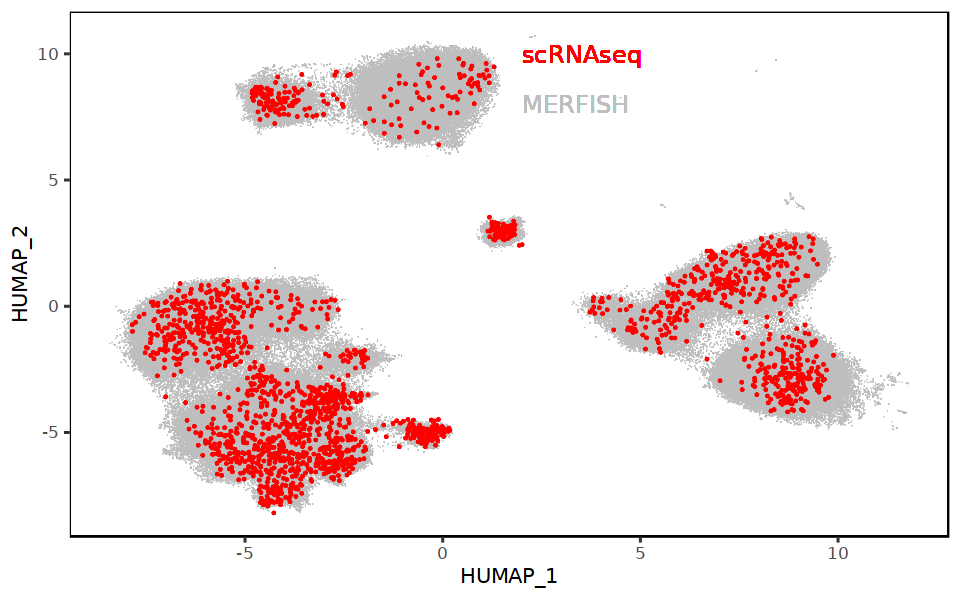

In [19]:
fig.size(5, 8)
p0 = meta_data %>% 
    ggplot(aes(HUMAP_1, HUMAP_2)) + 
        geom_point_rast(data = . %>% filter(type == 'spatial'), shape = '.', color = 'grey') + 
        geom_point_rast(data = . %>% filter(type == 'sc'), size = .5, color = 'red') + 
        geom_text(label = 'MERFISH', x = 2, y = 8, color = 'grey', size = 5, hjust=0) + 
        geom_text(label = 'scRNAseq', x = 2, y = 10, color = 'red', size = 5, hjust=0) + 
        NULL
p0


## UMAP - types

In [20]:
do_scatter = function (umap_use, meta_data, label_name, facet_var, no_guides = TRUE, 
    do_labels = TRUE, nice_names, palette_use = colors_overload, 
    pt_size = 4, point_size = 0.5, pt_shape = ".", base_size = 20, 
    do_points = TRUE, do_density = FALSE, h = 3, w = 4, alpha_fore = 1, 
    alpha_back = 0.3, color_back = "lightgrey", nrow = 1, do_raster = FALSE, 
    empty_theme = FALSE) 
{
    if (do_raster) {
        geom_point_fxn <- function(...) geom_point_rast(..., 
            width = w, height = h)
    }
    else {
        geom_point_fxn <- geom_point
    }
    plt_df <- data.frame(umap_use)[, 1:2]
    colnames(plt_df) <- c("X1", "X2")
    plt_df <- plt_df %>% cbind(meta_data) %>% dplyr::sample_frac(1L)
    plt_df$given_name <- plt_df[[label_name]]
    if (!missing(nice_names)) {
        plt_df %<>% dplyr::inner_join(nice_names, by = "given_name") %>% 
            subset(nice_name != "" & !is.na(nice_name))
        plt_df[[label_name]] <- plt_df$nice_name
    }
    plt <- plt_df %>% ggplot(aes_string("X1", "X2", col = label_name, 
        fill = label_name)) + guides(color = guide_legend(override.aes = list(stroke = 1, 
        alpha = 1, shape = 16, size = 4)), alpha = "none") + 
        scale_color_manual(values = palette_use) + scale_fill_manual(values = palette_use) + 
        theme(plot.title = element_text(hjust = 0.5)) + labs(x = "UMAP 1", 
        y = "UMAP 2")
    if (do_points) {
        if (!missing(facet_var)) {
            if (!is(facet_var, "quosure")) {
                stop("facet_var must be a quosure. e.g. quo('donor')")
            }
            plt <- plt + geom_point_fxn(data = dplyr::select(plt_df, 
                -!!facet_var), shape = pt_shape, size = point_size, 
                color = color_back, fill = color_back, alpha = alpha_back) + 
                facet_wrap(vars(!!facet_var), nrow = nrow)
        }
        plt <- plt + geom_point_fxn(shape = pt_shape, size = point_size, 
            alpha = alpha_fore)
    }
    if (do_density) 
        plt <- plt + geom_density_2d()
    if (no_guides) 
        plt <- plt + guides(col = "none", fill = "none", alpha = "none")
    if (do_labels) {
        plt <- plt + 
        # geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), 
        #     X2 = mean(X2)), by = label_name], aes_string(label = label_name, 
        #     color = label_name), fill = "white", size = pt_size, 
        #     alpha = 0.6) + 
        geom_text_repel(data = data.table(plt_df)[, 
            .(X1 = mean(X1), X2 = mean(X2)), by = label_name], 
            aes_string(label = label_name), color = "black", 
            size = pt_size, alpha = 1) + guides(col = "none", 
            fill = "none")
    }
    if (empty_theme) {
        plt <- plt + theme_void()
    }
    return(plt)
}

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message in geom_point(...):
“Ignoring unknown parameters: `width` and `height`”


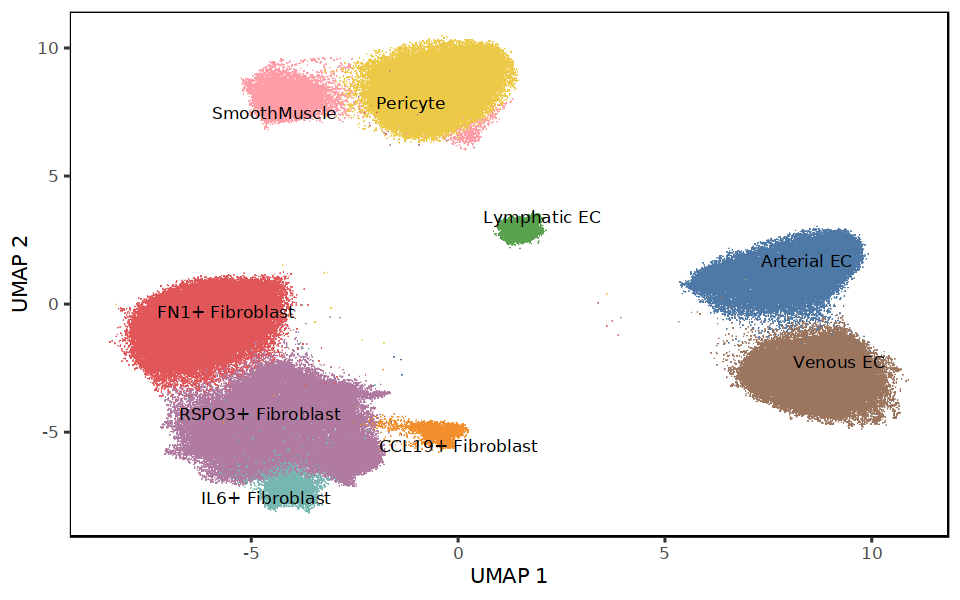

In [21]:
set.seed(1)
fig.size(5, 8)
i = which(
    !is.na(meta_data$type_lvl2) & meta_data$type_lvl2 != '' & 
    meta_data$type == 'spatial' & 
    TRUE
)

# i = sample(setdiff(seq_len(nrow(meta_data)), which(is.na(meta_data$type_lvl1))), 1e5)
# i_spa = which(meta_data$type)
p1 = do_scatter(
    # cells$U2$embedding[i, ], cells$meta_data[i, ], 
    dplyr::select(meta_data, HUMAP_1, HUMAP_2)[i, ], 
    dplyr::select(meta_data, -HUMAP_1, -HUMAP_2)[i, ], 
    'type_lvl2', do_labels = TRUE, 
    do_raster = TRUE, 
    pt_size = 3.5, 
    # do_raster = TRUE, 
    # palette_use = pal$type_lvl1
    palette_use = tableau_color_pal('Tableau 10')(10)
)  + 
    # scale_color_manual(values = pal$type_lvl1) ## do_scatter doesn't keep order of palette names
    # facet_wrap(~type) + 
    NULL
p1


# ggsave('figures/5a_umap_cells_coarse.pdf', plt, device = 'pdf', dpi = 300, units = 'in', height = 8, width = 12)
# ggsave('figures/5a_umap_cells_coarse.png', plt, device = 'png', dpi = 300, units = 'in', height = 8, width = 12)


## Heatmap - top markers

In [25]:
fig.size(3.5, 9)
g = markers_spa[, .SD[pvalue < .05 & logFC > 1][order(-logFC)][1:5], by = cluster][, unique(feature)]
# g = markers_spa[, .SD[fdr < .05 & order(-logFC)][1:5], by = cluster][, unique(feature)]
g = union(g, c('CXCL13', 'RSPO3', 'CXCL12', 'CXCL9', 'CXCL10', 'CXCL11'))
X = markers_spa[feature %in% g][, .(cluster, feature, zscore)] %>% 
    tidyr::spread(cluster, zscore) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% t()

o_row = hclust(dist(X))$order
X = X[o_row, ]
o_col = order(max.col(t(X)))
X = X[, o_col]

## make CXCL12 and CXCL13 go last 
X = cbind2(
    X[, setdiff(colnames(X), c('CXCL12', 'CXCL13', 'CXCL9', 'CXCL10', 'CXCL11'))],
    X[, c('CXCL12', 'CXCL13', 'CXCL9', 'CXCL10', 'CXCL11')]
)
    

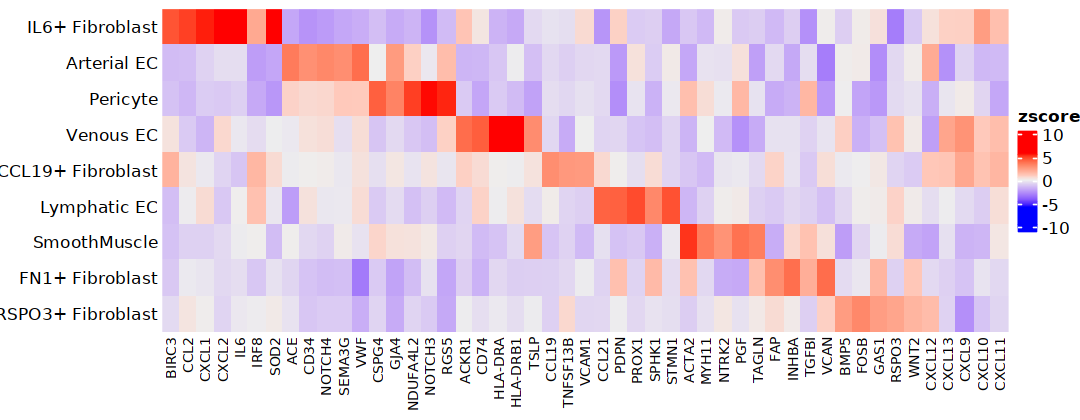

In [26]:
plt = X %>% 
    Heatmap(
        # col = colorRamp2(c(-3, 0, 3), c('white', 'lightgrey', muted('blue'))), 
        name = 'zscore', 
        cluster_rows = FALSE, cluster_columns = FALSE, 
        # show_row_dend = FALSE, show_column_dend = FALSE,
        column_names_gp = grid::gpar(fontsize = 8),
        row_names_gp = grid::gpar(fontsize = 10),
        row_names_side = 'left', 
        use_raster = TRUE
    )

plt = grid.grabExpr(
    draw(
        plt
        # padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
    )    
) 
# p2 = wrap_elements(plt)
p2 = wrap_elements(full = plt)
p2


In [27]:
ggsave('figures/stromal_heatmap.pdf', p2, device = 'pdf', units = 'in', width = 9, height = 3.5, dpi = 300)
ggsave('figures/stromal_heatmap.png', p2, device = 'png', units = 'in', width = 9, height = 3.5, dpi = 300)


## UMAP - CCL19

In [23]:
vals = normalizeData(counts, median(colSums(counts)), 'log')['CCL19', ]

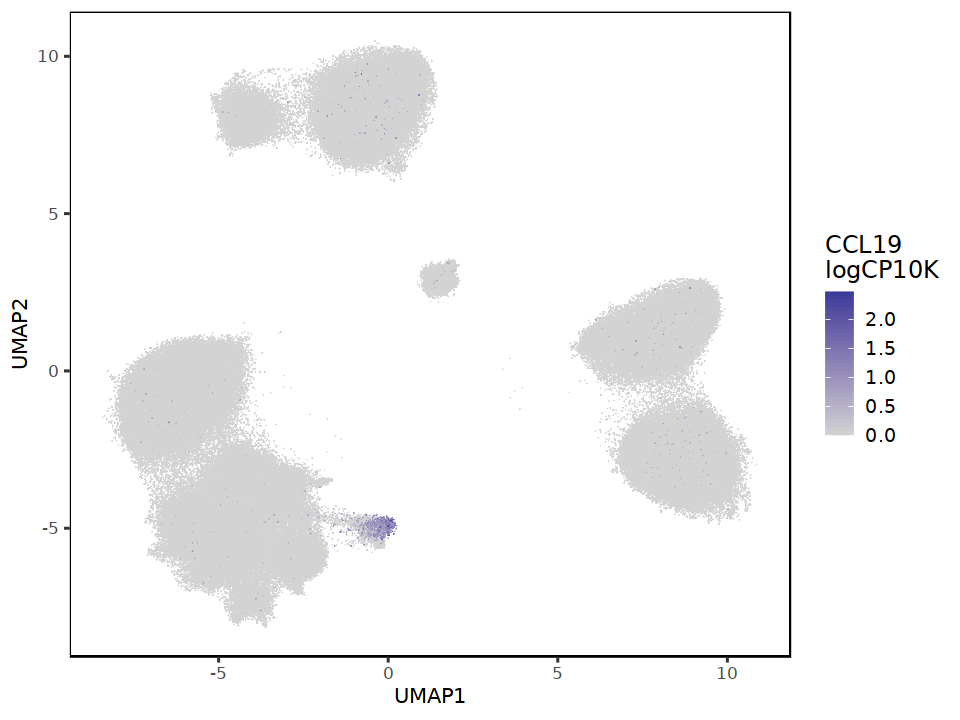

In [24]:
fig.size(6, 8)
p3 = meta_data %>% 
    cbind(CCL19 = vals) %>% 
    filter(type_lvl2 != '' & type == 'spatial') %>% 
    ggplot(aes(HUMAP_1, HUMAP_2)) + 
        geom_point_rast(shape = '.', aes(color = CCL19)) + 
        scale_color_gradient2(midpoint = 0, mid = 'lightgrey') + 
        labs(x = 'UMAP1', y = 'UMAP2', color = 'CCL19\nlogCP10K') + 
        NULL
p3

## Cell abundance - scatter

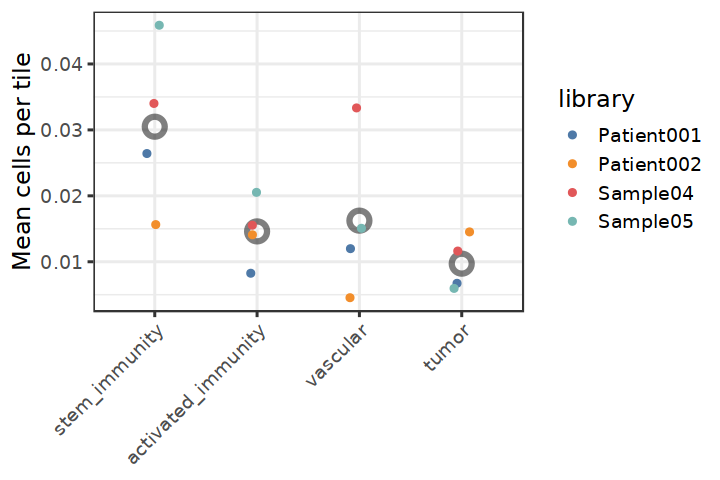

In [30]:
df = data.table(meta_data)[
    type == 'spatial'
    # type_lvl1 %in% c('Lymphocyte', 'Mast', 'Plasma', 'Myeloid')
    # type_lvl1 %in% c('Fibroblast', 'SmoothMuscle', 'Pericyte')
    # type_lvl1 %in% c('Fibroblast', 'Endothelial', 'SmoothMuscle', 'Pericyte')
][
    type_lvl2 != ''
    # , type_lvl2 := case_when(
    #     grepl('CXCL13', type_lvl2) ~ 'CXCL13 T', 
    #     TRUE ~ type_lvl2
    # )
][
    , .N, by = .(hubID, hubSize_tiles, hubSize_um2, library, hubType, type_lvl2)
] %>% 
    dplyr::mutate(density = N / hubSize_tiles) 

df = df %>% # number of cells per tile 
    tidyr::spread(type_lvl2, density, fill = 0) %>% 
    tidyr::gather(type_lvl2, density, all_of(na.omit(unique(df$type_lvl2))))

df_mean = data.table(df)[][
    ## mean density for each hub 
    , .(mu = mean(density)), 
    by = .(hubType, library, type_lvl2, hubID)
][
    ## average over hubs inside library:hubType
    , 
    .(mu = mean(mu), sigma = sd(mu)), 
    by = .(hubType, type_lvl2, library)
    
]

# df_mean$hubType <- factor(df_mean$hubType, c('tumor', 'vascular', 'immune_hub', 'hybrid_hub'))
df_mean$hubType <- factor(df_mean$hubType, rev(c('tumor', 'vascular', 'activated_immunity', 'stem_immunity')))
# df_mean$hubType <- factor(df_mean$hubType, rev(c('tumor', 'vascular', 'immune_hub', 'hybrid_hub')))

types_show = meta_data %>% 
    filter(type_lvl2 %in% c('CCL19+ Fibroblast')) %>% 
    # filter(type_lvl1 %in% c('Fibroblast', 'SmoothMuscle', 'Pericyte')) %>% 
    with(unique(type_lvl2))

p4 = df_mean %>% 
    filter(type_lvl2 %in% types_show) %>% 
    ggplot(aes(hubType, mu, color = library)) + 
        geom_point(
            data = df_mean[type_lvl2 %in% types_show, .(mu = mean(mu)), by = .(hubType, type_lvl2)], 
            color = 'black', size = 4, shape = 21, alpha = .5, stroke = 2
        ) + 
        geom_point(position = position_jitter(width = .1, height = 0)) + 
        # geom_line(aes(group = library), alpha = .3) + 
        # facet_wrap(~type_lvl2, scales = 'free_y', nrow = 2) + 
        theme_bw(base_size = 14) + 
        theme(
            axis.text.x = element_text(angle = 45, hjust = 1),
            axis.title.x = element_blank()
        ) + 
        labs(x = 'Region type', y = 'Mean cells per tile') + 
        scale_color_tableau() + 
        NULL

fig.size(4, 6)
# fig.size(6, 14)
p4


In [31]:
df_mean[type_lvl2 == 'CCL19+ Fibroblast'][order(-mu)]


hubType,type_lvl2,library,mu,sigma
<fct>,<chr>,<chr>,<dbl>,<dbl>
stem_immunity,CCL19+ Fibroblast,Sample05,0.045871981,0.051273373
stem_immunity,CCL19+ Fibroblast,Sample04,0.034008265,0.104892626
vascular,CCL19+ Fibroblast,Sample04,0.033331749,0.071103147
stem_immunity,CCL19+ Fibroblast,Patient001,0.026414099,0.046174558
activated_immunity,CCL19+ Fibroblast,Sample05,0.020524801,0.045699776
stem_immunity,CCL19+ Fibroblast,Patient002,0.015635976,0.033672703
activated_immunity,CCL19+ Fibroblast,Sample04,0.015537291,0.050739179
vascular,CCL19+ Fibroblast,Sample05,0.015074851,0.031986360
tumor,CCL19+ Fibroblast,Patient002,0.014526194,0.033537805


In [32]:
df_mean$hubType = as.character(df_mean$hubType)
df_mean$hubType = factor(df_mean$hubType, c('tumor', 'stem_immunity', 'activated_immunity', 'vascular'))


In [37]:
lm(
    mu ~ 1 + hubType + library, 
    # df_mean[type_lvl2 == 'CCL19+ Fibroblast'][hubType %in% c('tumor', 'stem_immunity')]
    df_mean[type_lvl2 == 'CCL19+ Fibroblast']
) %>% 
    broom::tidy() %>% 
    filter(grepl('hubType', term)) %>% 
    dplyr::mutate(fdr = p.adjust(p.value, 'BH'))


term,estimate,std.error,statistic,p.value,fdr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hubTypestem_immunity,0.020773657,0.006030203,3.4449347,0.00733313,0.02199939
hubTypeactivated_immunity,0.004893614,0.006030203,0.8115172,0.43800354,0.43800354
hubTypevascular,0.006525596,0.006030203,1.0821520,0.30732562,0.43800354


In [12]:
markers_ref[feature == 'CCL19'][, logFC := logFC / log(2)][]
markers_spa[feature == 'CCL19'][, logFC := logFC / log(2)][]


cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCL19+ Fibroblast,CCL19,11.5250595,2.069732,3.8597083,5.676123e-05,0.0006535889
IL6+ Fibroblast,CCL19,2.1522062,1.937428,0.7699878,2.206536e-01,0.7124607463
Pericyte,CCL19,1.2060500,1.153581,0.7246743,2.343259e-01,0.7443294801
RSPO3+ Fibroblast,CCL19,0.3470877,1.044427,0.2303491,4.089103e-01,1.0000000000
FN1+ Fibroblast,CCL19,-1.1512893,2.297224,-0.3473815,6.358476e-01,1.0000000000
SmoothMuscle,CCL19,-2.1185456,1.314641,-1.1170074,8.680044e-01,1.0000000000
Lymphatic EC,CCL19,-2.7536976,1.349913,-1.4139558,9.213126e-01,1.0000000000
Arterial EC,CCL19,-4.2852331,1.240314,-2.3947940,9.916851e-01,1.0000000000
Venous EC,CCL19,-4.9216379,1.343046,-2.5400621,9.944584e-01,1.0000000000


cluster,feature,logFC,SD,zscore,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCL19+ Fibroblast,CCL19,9.3909671,1.985154,3.27900178,0.0005208749,0.01117384
Lymphatic EC,CCL19,0.1578860,1.222030,0.08955443,0.4643206474,0.99998603
IL6+ Fibroblast,CCL19,-0.4655093,1.014951,-0.31791334,0.6247246620,0.99998603
Pericyte,CCL19,-0.9203307,1.319045,-0.48362617,0.6856743999,0.99998603
Arterial EC,CCL19,-1.5188730,1.671310,-0.62992656,0.7356286831,0.99998603
Venous EC,CCL19,-0.9892125,1.036292,-0.66165700,0.7459044645,0.99998603
FN1+ Fibroblast,CCL19,-1.9639454,1.710322,-0.79593391,0.7869647754,0.99998603
RSPO3+ Fibroblast,CCL19,-1.6843791,1.392872,-0.83821235,0.7990442753,0.99998603
SmoothMuscle,CCL19,-2.0066032,1.163910,-1.19499865,0.8839562222,0.99998603


## Heatmap of co-localization 

In [90]:
res = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats_revision.csv')
library(stringr)
if ('freq_perm' %in% colnames(res)) {
    res$freq_perm = res$freq_perm %>% str_split('\\|') %>% map(as.numeric)    
}

## Make nice names 
res = res %>% 
    dplyr::mutate(index_type = case_when(
        index_type %in% c('FN+') ~ 'FN1+ Fibroblast',
        index_type %in% c('CCL19+', 'IL6+', 'RSPO3+') ~ paste0(index_type, ' Fibroblast'),
        index_type %in% c('Venous', 'Arterial', 'Lymphatic') ~ paste0(index_type, ' EC'),
        TRUE ~ index_type
    )) %>% 
    dplyr::mutate(type = case_when(
        type %in% c('FN+') ~ 'FN1+ Fibroblast',
        type %in% c('CCL19+', 'IL6+', 'RSPO3+') ~ paste0(type, ' Fibroblast'),
        type %in% c('Venous', 'Arterial', 'Lymphatic') ~ paste0(type, ' EC'),
        TRUE ~ type
    )) 

types = c('hybrid_hub', 'immune_hub', 'tumor', 'vascular')
types_nice = c('stem_immunity', 'activated_immunity', 'tumor', 'vascular')
o = match(res$hubType, types)
res$hubType = types_nice[o]


In [91]:
writeLines(sort(unique(res$type)))


Arterial EC
B
CCL19+ Fibroblast
CD1C+ITGAX+ DC
CD4 T
CD8 T
CXCL10+ Macrophage
CXCL13+ CD4 T
CXCL13+ CD8 T
Epithelial
FCN1+LYZ+ Macrophage
FLT3+ DC
FN1+ Fibroblast
FOLR2+CD14+ Macrophage
IL6+ Fibroblast
ILC
LAMP3+CCL19+ mreg DC
LAMP3+CD1C+ DC
Lymphatic EC
MARCO+ Macrophage
Mast
MERTK+ Macrophage
MMP1+SOX4+ Myeloid
NCAM1+ S100B+ SEPP1+ Myeloid
NK
Pericyte
PLA2G7+ CCL18+ Macrophage
Plasma
RSPO3+ Fibroblast
SmoothMuscle
SPP1+ Macrophage
TCF7+ CD4 T
TCF7+ CD8 T
TCF7+PD1+ CD8 T
Treg
Venous EC


In [92]:
unique(meta_data$type_lvl2)

[1] ""                  "Venous EC"         "FN1+ Fibroblast"  
 [4] "Arterial EC"       "RSPO3+ Fibroblast" "Pericyte"         
 [7] "IL6+ Fibroblast"   "SmoothMuscle"      "Lymphatic EC"     
[10] "CCL19+ Fibroblast"

In [93]:
unique(res$index_type)

[1] "Epithelial"                   "RSPO3+ Fibroblast"           
 [3] "LAMP3+CCL19+ mreg DC"         "Plasma"                      
 [5] "FN1+ Fibroblast"              "SPP1+ Macrophage"            
 [7] "ILC"                          "Mast"                        
 [9] "FOLR2+CD14+ Macrophage"       "CD1C+ITGAX+ DC"              
[11] "MARCO+ Macrophage"            "CD8 T"                       
[13] "Treg"                         "Pericyte"                    
[15] "MMP1+SOX4+ Myeloid"           "MERTK+ Macrophage"           
[17] "IL6+ Fibroblast"              "LAMP3+CD1C+ DC"              
[19] "CD4 T"                        "TCF7+ CD8 T"                 
[21] "Arterial EC"                  "CXCL10+ Macrophage"          
[23] "FLT3+ DC"                     "CXCL13+ CD4 T"               
[25] "TCF7+PD1+ CD8 T"              "PLA2G7+ CCL18+ Macrophage"   
[27] "FCN1+LYZ+ Macrophage"         "NCAM1+ S100B+ SEPP1+ Myeloid"
[29] "B"                            "Venous EC"                   
[31] "TCF7+ CD4 T"                  "Lymphatic EC"                
[33] "SmoothMuscle"                 "CXCL13+ CD8 T"               
[35] "CCL19+ Fibroblast"            "NK"

In [94]:

res_meta = left_join(
    res, 
    meta_all[, .N, by = .(hubType, type_lvl2, library)][, Ntot := sum(N), by = .(hubType, type_lvl2)][, w := N/Ntot][, .(hubType, index_type = type_lvl2, library, w)]
)[
    , .(freq = sum(w*freq)/sqrt(sum(w^2)), zscore = sum(w*zscore)/sqrt(sum(w^2))), 
    , by = .(index_type, type, hubType)
][
    , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed    
][
    , fdr := pmin(pval * nrow(res), 1) ## bonferroni     
][]


Joining with `by = join_by(library, hubType, index_type)`


In [96]:
fwrite(res_meta, '../data/colocalization_stats_revision_meta.csv')

In [100]:
.hubtype = 'stem_immunity'
.title = 'Colocalization inside stem-immunity'
stat = 'zscore'

In [101]:
.celltypes = grep('Fibro|Peri|EC', unique(res_meta$index_type), value = TRUE, ignore.case = TRUE)


In [102]:
# foo = function(.hubtype, .title, .celltypes = NULL, stat = 'zscore') {
    X = res_meta[hubType == .hubtype]
    X$SCORE = X[[stat]]
    if (stat == 'zscore') {
        stat_max = 10        
    } else {
        stat_max = max(X$SCORE)
    }

    ## wide matrix of FDR values 
    X_fdr = X[, .(index_type, type, fdr)] %>%
        data.frame() %>% 
        tidyr::spread(type, fdr, fill = NA) %>% 
        tibble::column_to_rownames('index_type') %>% 
        as.matrix() 

    ## wide matrix of zscores or frequencies 
    X = X[, .(index_type, type, SCORE)] %>%
        data.frame() %>% 
        tidyr::spread(type, SCORE, fill = NA) %>% 
        tibble::column_to_rownames('index_type') %>% 
        as.matrix() 
    # print(X)

    if (!is.null(.celltypes)) {
        X = X[.celltypes, ]
        X_fdr = X_fdr[.celltypes, ]
        
    }
        # X = X[.celltypes, .celltypes]
    # print(X)

    
    X = pmin(X, stat_max)
    # print(X)
    # o = hclust(dist(t(X)))$order
    # o = hclust(dist(X))$order
    # o2 = hclust(dist(t(X)))$order

    mat_text = matrix('', nrow = nrow(X), ncol = ncol(X))

    mat_text[X_fdr < .05] = '*'
    # mat_text = mat_text[, o]
    # mat_text = mat_text[o, o]

In [103]:
o = rev(order(apply(X, 2, max, na.rm = TRUE)))
# o = rev(order(colSums(X, na.rm = TRUE)))
X = X[, o]
mat_text = mat_text[, o]

In [109]:
colnames(X)[colnames(X) == 'CD4 T'] = 'TCF7- CD4 T'
colnames(X)[colnames(X) == 'CD8 T'] = 'TCF7- CD8 T'
rownames(X)[rownames(X) == 'CD4 T'] = 'TCF7- CD4 T'
rownames(X)[rownames(X) == 'CD8 T'] = 'TCF7- CD8 T'


In [110]:
    plt = Heatmap(
        matrix = X, 
        # matrix = X[, o], 
        # matrix = X[o1, o2], 
        rect_gp = gpar(col = "white", lwd = 2), 
        cluster_columns = FALSE, 
        cluster_rows = FALSE, 
        use_raster = TRUE, 
        name = stat,
        col = colorRamp2(c(-stat_max, 0, stat_max), c('blue', 'white', 'red')),
        # col = colorRamp2(c(-stat_max, 0, stat_max), c(muted('red'), 'white', muted('blue'))),
        # col = colorRamp2(c(-stat_max, 0, stat_max), c('white', 'white', muted('blue'))),
        column_title = .title,
        column_names_gp = grid::gpar(fontsize = 10),
        row_names_side = 'left', 
        cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
            grid.text(mat_text[i, j], x, y)
        }
    )

    plt <- grid.grabExpr(
        draw(
            plt, 
            padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
        )    
    ) 
    plt <- wrap_elements(full = plt)
    # plt    
# }
p5 = plt

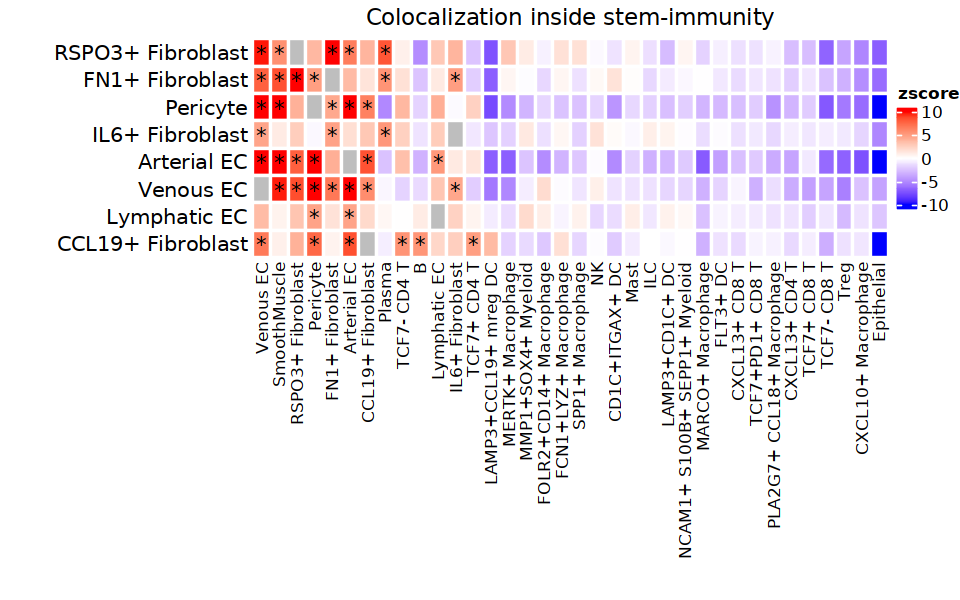

In [111]:
fig.size(5, 8)
p5


In [115]:
ggsave('figures/stromal_colocalization.pdf', p5, device = 'pdf', units = 'in', width = 8, height = 5, dpi = 300)
ggsave('figures/stromal_colocalization.png', p5, device = 'png', units = 'in', width = 8, height = 5, dpi = 300)


## MAIN

In [36]:
# fig.size(12, 10)
# plt = (
#     # (p1 | p2 | p3) + plot_layout(widths = c(2, 3, 2))
#     (p1 | p2) + plot_layout(widths = c(1, 1.5))
# ) / 
# (
#     (p3 | p4) + plot_layout(widths = c(1, 1))
# ) / (
#     p5
# ) + 
#     plot_annotation(tag_levels = 'a') + 
#     plot_layout(heights = c(1, 1, 1.2)) + 
#     NULL
# plt


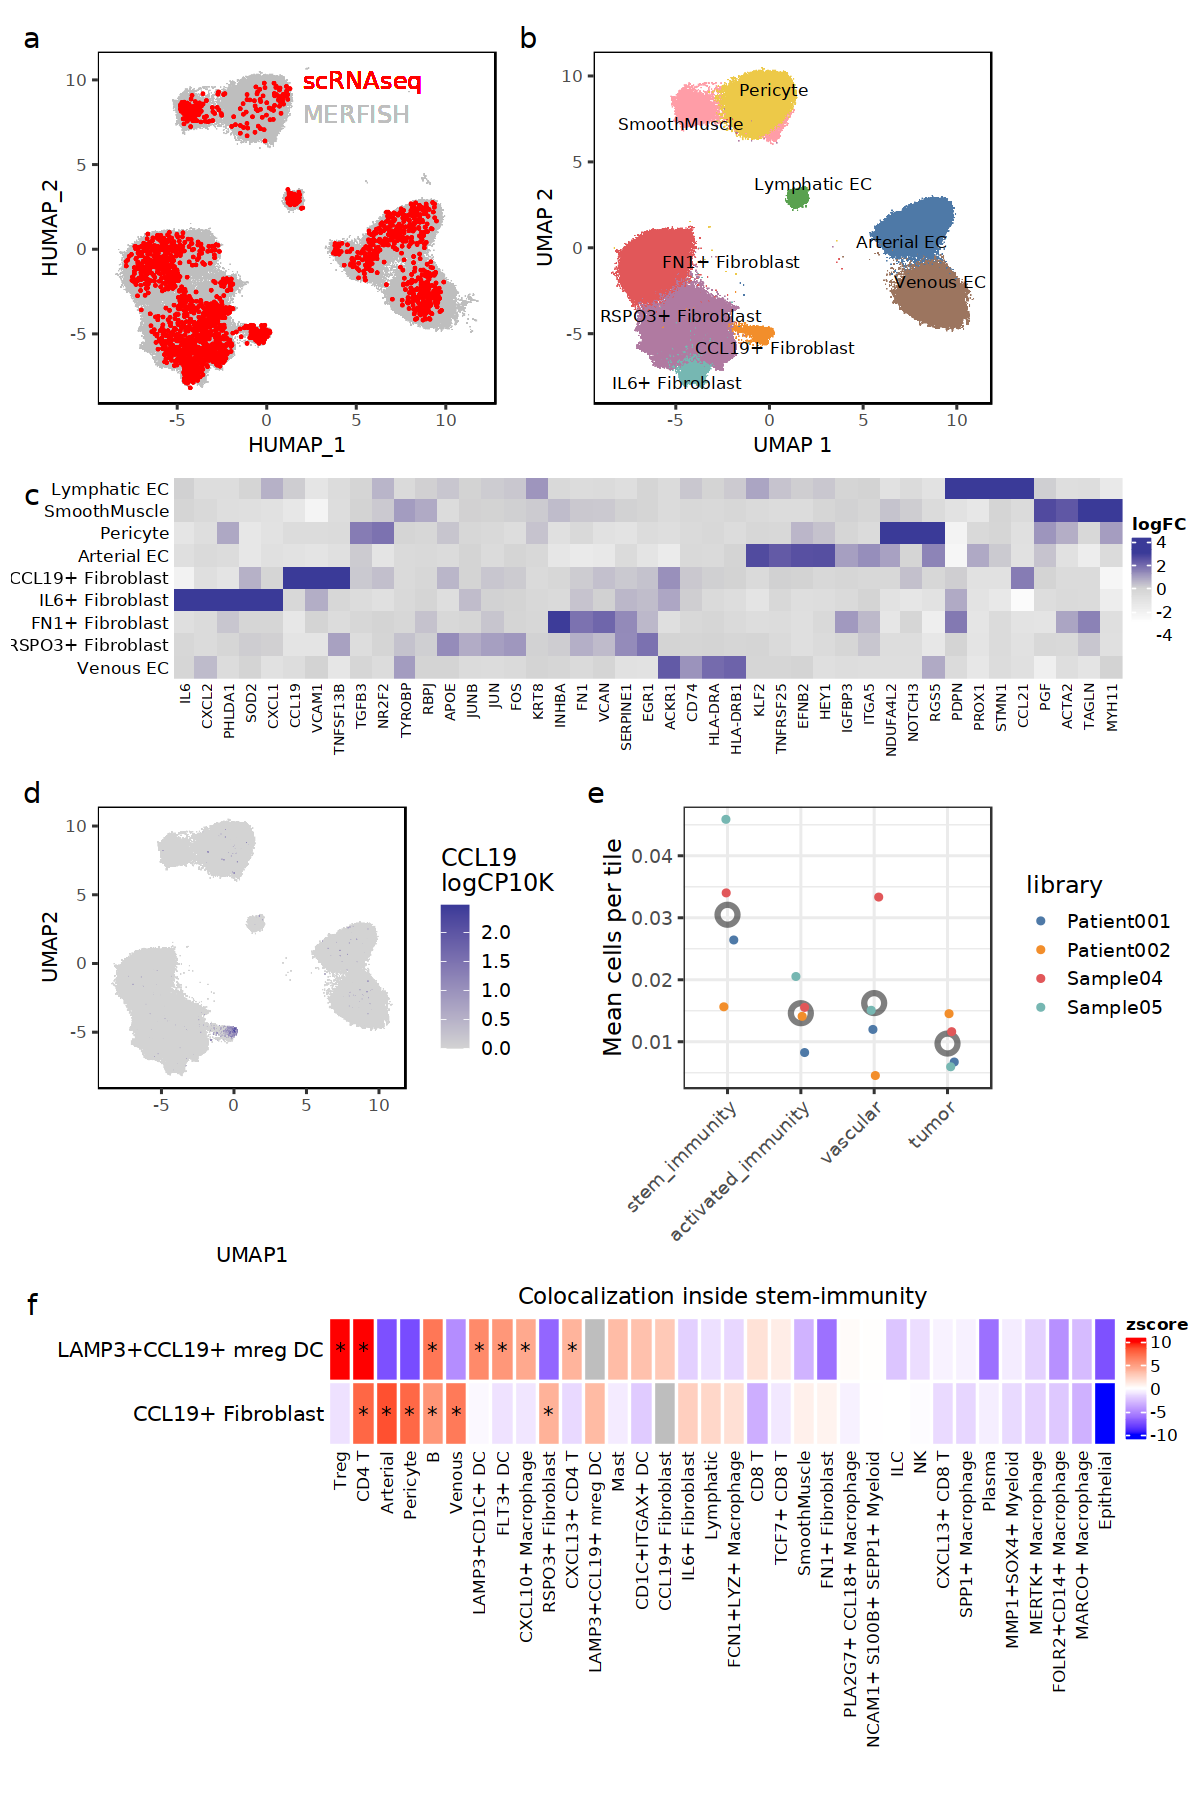

In [37]:
fig.size(15, 10)
plt = (
    # (p1 | p2 | p3) + plot_layout(widths = c(2, 3, 2))
    (p0 | p1) + plot_layout(widths = c(1, 1))
) / 
(
    p2
) / 
(
    (p3 | p4) + plot_layout(widths = c(1, 1))
    # (p2 | p3 | p4) + plot_layout(widths = c(1, 1, 1))
) / (
    p5
) + 
    plot_annotation(tag_levels = 'a') + 
    plot_layout(heights = c(1, .7, .8, 1.3)) + 
    NULL
plt


In [38]:
ggsave('figures/ccl19_suppfig.pdf', plt, device = 'pdf', units = 'in', width = 10, height = 15, dpi = 300)
ggsave('figures/ccl19_suppfig.png', plt, device = 'png', units = 'in', width = 10, height = 15, dpi = 300)
